# This workbooks provides a tool to pre-select sources to be spectroscopically analyzed with SAMOS.

22/12/2024 - Version 5.0:
- removed all cells commented out using  %%script false --no-raise-error.
  
22/12/2024 - Version 4.9:
- ranking is now pushed out of the notebook, i.e. the table is exported to .csf file and has to be ranked using e.g. MSexcel.
- rewritten the slit configuration:
  * a rectangular trace is created for each target; the trace/target is accepted if it does not overlap with the previous ones on a 2d array (simulates actual image). 
  * the order of injected traces is generated multiple times, randomly scrambling the weight=1 sample; the configuration providing the maximum number of targets and weight 1 targets is selected as mask0.
  * the process is repeated on the remaining targets, finding mask1, mask2 etc up to a limit (currently set to 5, i.e. mask4)
- a lot of stuff relative to the mask selection is no more needed and commented out using %%script false --no-raise-error.
 
20/12/2024 - Version 4.8:
- added the possibility of creating regions startinbg from RADEC not from target name
- list is sorted by Declination
- creates even and odd tables to use at the telescope from trace identification

## Runs with "samos" environment (20/12/2024)

## It is divided in 4 main parts:

### 1) Selection of the target catalog

### 2) Display of the targets and pre-selection of the slits

### 3) Ranking and final slit list(s)

### 4) Selection of suitable guide stars

## Initial imports

In [1]:
#import ipyaladin.aladin_widget as ipyal
from ipyaladin import Aladin
from ipywidgets import Layout#, Box, widgets
import pandas as pd
from astroquery.simbad import Simbad
import astropy.units as u
from astropy import coordinates#, units as u, wcs

from astroquery.vizier import Vizier
from astropy.io.votable import parse
from astropy.table import Table, Column
import numpy as np
import matplotlib.pyplot as plt
import copy

from regions import RectangleSkyRegion, Regions
from astropy.coordinates import SkyCoord
#from astropy import units as u
import os as os
#import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.patches import Rectangle
    
from astropy.wcs import WCS
import astropy.wcs as wcs
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
#from astropy import units as u
from astropy.visualization.wcsaxes import Quadrangle
#from astropy.coordinates import SkyCoord

from astropy.time import Time
#from astropy.io import fits

import astropy.coordinates as coord
from astroquery.gaia import Gaia
import urllib.request
import shutil
import tempfile
import re

from regions import PixCoord

import pyvo as vo
from astropy.utils.data import download_file
from astropy.nddata import Cutout2D

%matplotlib inline

In [2]:
#SETUP THE DIRECTORY
cwd = os.getcwd()

## Step 0: declare the target field and get the Simbad coordinates

In [3]:
Target_name_SIMBAD = ""
#Target_name_SIMBAD = "M 13"
#Target_name_SIMBAD = "IDCS J1426.5+3508"
#Target_name_SIMBAD = "M 42"
#Target_name_SIMBAD = "NGC 3105"
#Target_name_SIMBAD = "NGC 6281"
#Target_name_SIMBAD = "Sh2-210"
# NORTHERN EXAMPLE: 
#Target_name_SIMBAD = "Crab Nebula"


#try:
#    Target_name_SIMBAD
#except NameError:
#    print('No target name given. Simbad will use coordinates')
#    Target_name_SIMBAD = ""
    

if Target_name_SIMBAD == "":
    
    ra = 150.17 #your ra here, e.g. 150.16916666666665 
    dec = -54.79 #your dec gere, e.g. -54.79
    result_table = Simbad.query_region(SkyCoord( ra, dec, unit=(u.deg, u.deg),
                    frame='fk5'), radius=180 * u.arcsec)
    print(result_table)
    radec_center = coord.SkyCoord(ra,dec,unit=(u.deg,u.deg), frame='icrs')
    print(radec_center)
    Posx = radec_center.ra.value ; print(Posx.dtype)
    Posy = radec_center.dec.value; print(Posy.dtype)
    Target_name = result_table['MAIN_ID'][0]
    print(Target_name)

else:
    Target_name = Target_name_SIMBAD
    result_table = Simbad.query_object(Target_name)
    ra = result_table['RA']
    dec = result_table['DEC']
    radec_center = coord.SkyCoord(ra,dec,unit=(u.hourangle,u.deg), frame='icrs')[0]
    Posx = radec_center.ra.value ; print(Posx.dtype)
    Posy = radec_center.dec.value; print(Posy.dtype)
print(result_table)
    
print(radec_center.ra.value)    
#Posx = radec_center.ra.value[0] ; print(Posx.dtype)
#Posy = radec_center.dec.value[0]; print(Posy.dtype)
Pos = SkyCoord(ra=Posx, dec=Posy, unit='deg')
    
#print(radec_center.ra.value[0],radec_center.dec.value[0])
print(Posx)

dir_name = os.path.join(cwd, Target_name)
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
filename = Target_name+"_slits.reg"



          MAIN_ID                  RA      ... SCRIPT_NUMBER_ID
                                "h:m:s"    ...                 
---------------------------- ------------- ... ----------------
                 AM 0958-543      10 00 41 ...                1
Gaia DR3 5260177495457182464 10 00 40.6092 ...                1
                   NGC  3105    10 00 40.6 ...                1
Gaia DR3 5260177495457181824 10 00 40.5349 ...                1
Gaia DR3 5260177499778947072 10 00 40.5857 ...                1
Gaia DR3 5260177499778947200 10 00 40.3553 ...                1
              [FSR2007] 1519    10 00 41.7 ...                1
             NGC  3105    16 10 00 40.7628 ...                1
Gaia DR3 5260177499778945152 10 00 39.7752 ...                1
                         ...           ... ...              ...
Gaia DR3 5260189147731318144 10 00 24.9246 ...                1
Gaia DR3 5260189147731317888 10 00 24.2719 ...                1
Gaia DR3 5260177912095841664 10 00 36.95

# STEP 1) Selection of the target catalog¶
   
## We illustrate 4 ways to create the source catalog

### 1.1) Simbad: Extract Astropy table from the entries on Simbad, generally just a mix of sources

### 1.2) Vizier: Extract Astropy table from published dataset on Vizier

### 1.3) Create and Astropy table from your own catalog on local disk

### 1.4) Vizier+your own: Create an astropy table from my file + Vizier X-match


# 1.1) Simbad: Extract Astropy table from Simbad

We start extracting all objects that have an entry on Simbad, i.e. sources that appear in published journal catalogs. 

"This is a class designed to represent tables of heterogeneous data. It is better than a numpy structured array because of the ability to easily modify the structure of the table by adding or removing columns, or adding new rows of data. In addition table and column metadata are fully supported." 

See 
http://docs.astropy.org/en/stable/api/astropy.table.Table.html#astropy.table.Table

In [4]:
#%%script false --no-raise-error
#COMMENT THE LINE ABOVE TO RUN THIS CELL
#=======================================

#simbad.SIMBAD_URL = 'http://simbad.harvard.edu/simbad/sim-script'

#To query Simbad, see https://astroquery.readthedocs.io/en/latest/simbad/simbad.html
#result_table = simbad.query_region("m81", radius="0.5d")
#table_1 = Simbad.query_region(Target_name, radius="0.05d")

if Target_name_SIMBAD == "":
    table_1 = Simbad.query_region(SkyCoord( ra, dec, unit=(u.deg, u.deg),
                    frame='fk5'), radius=180 * u.arcsec)
else:
    Target_name = Target_name_SIMBAD
    table_1 = Simbad.query_object(Target_name)



#this defines the Astropy"table" that we will use later
#
print(table_1.colnames)
print(table_1)

['MAIN_ID', 'RA', 'DEC', 'RA_PREC', 'DEC_PREC', 'COO_ERR_MAJA', 'COO_ERR_MINA', 'COO_ERR_ANGLE', 'COO_QUAL', 'COO_WAVELENGTH', 'COO_BIBCODE', 'SCRIPT_NUMBER_ID']
          MAIN_ID                  RA      ... SCRIPT_NUMBER_ID
                                "h:m:s"    ...                 
---------------------------- ------------- ... ----------------
                 AM 0958-543      10 00 41 ...                1
Gaia DR3 5260177495457182464 10 00 40.6092 ...                1
                   NGC  3105    10 00 40.6 ...                1
Gaia DR3 5260177495457181824 10 00 40.5349 ...                1
Gaia DR3 5260177499778947072 10 00 40.5857 ...                1
Gaia DR3 5260177499778947200 10 00 40.3553 ...                1
              [FSR2007] 1519    10 00 41.7 ...                1
             NGC  3105    16 10 00 40.7628 ...                1
Gaia DR3 5260177499778945152 10 00 39.7752 ...                1
                         ...           ... ...              ...
Gaia D

In [5]:
#%%script false --no-raise-error
#COMMENT THE LINE ABOVE TO RUN THIS CELL
#=======================================
# ... and some preparation may be needed, for example
#table_1.rename_column('RAJ2000', 'RA')
#table_1.rename_column('DEJ2000', 'DEC')
#table_1.rename_column('ID', 'MainID')

#add an "index" column
table_1.add_column(np.arange(len(table_1)), name='index', index=0)
print(table_1.colnames)



['index', 'MAIN_ID', 'RA', 'DEC', 'RA_PREC', 'DEC_PREC', 'COO_ERR_MAJA', 'COO_ERR_MINA', 'COO_ERR_ANGLE', 'COO_QUAL', 'COO_WAVELENGTH', 'COO_BIBCODE', 'SCRIPT_NUMBER_ID']


# 1.2) Vizier: Extract Astropy table from published dataset on Vizier

## example here is Gaia DR2, or any other table from a published paper (go to find it...)

In [6]:
#%%script false --no-raise-error
#COMMENT THE LINE ABOVE TO RUN
#==================================




if Target_name_SIMBAD == "":
#    table_1 = Simbad.query_region(SkyCoord( ra, dec, unit=(u.deg, u.deg),
#                    frame='fk5'), radius=180 * u.arcsec)
    center = coordinates.SkyCoord( ra, dec, unit=(u.deg, u.deg),
                    frame='fk5')
else:
    Target_name = Target_name_SIMBAD
    center = coordinates.SkyCoord.from_name(Target_name)

Vizier.ROW_LIMIT = -1
tablelist = Vizier.query_region(center, radius=2*u.arcmin,
#                                catalog='J/ApJ/826/16/table1')
#                                catalog='J/A+A/616/A124'
                               catalog='I/345/gaia2',column_filters={'Gmag': '<19'})
# Vizier.query_region returns a "tablelist" table, 
# a class that inherits from list but included some pretty printing methods for astropy.table.Table objects.
#see
#https://astroquery.readthedocs.io/en/latest/api/astroquery.utils.TableList.html#astroquery.utils.TableList

# the result may be a list of tables, so here we'll get the first one
table_2 = tablelist[0]
#print(table_2[0:5])

#CHECK!
print(table_2.colnames)
table_2

['RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'Source', 'Plx', 'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'Dup', 'FG', 'e_FG', 'Gmag', 'e_Gmag', 'FBP', 'e_FBP', 'BPmag', 'e_BPmag', 'FRP', 'e_FRP', 'RPmag', 'e_RPmag', 'BP-RP', 'RV', 'e_RV', 'Teff', 'AG', 'E_BP-RP_', 'Rad', 'Lum']


RA_ICRS,e_RA_ICRS,DE_ICRS,e_DE_ICRS,Source,Plx,e_Plx,pmRA,e_pmRA,pmDE,e_pmDE,Dup,FG,e_FG,Gmag,e_Gmag,FBP,e_FBP,BPmag,e_BPmag,FRP,e_FRP,RPmag,e_RPmag,BP-RP,RV,e_RV,Teff,AG,E_BP-RP_,Rad,Lum
deg,mas,deg,mas,,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,,,mag,mag,,,mag,mag,,,mag,mag,mag,km / s,km / s,K,mag,mag,solRad,solLum
float64,float64,float64,float64,int64,float64,float32,float64,float32,float64,float32,uint8,float32,float32,float64,float64,float32,float32,float64,float64,float32,float32,float64,float64,float64,float64,float32,float64,float32,float32,float32,float64
150.20927750333,0.0783,-54.81138383982,0.0725,5260176670827454848,0.2056,0.0927,-4.727,0.156,3.745,0.133,0,1939,2.097,17.4696,0.0012,791.1,8.713,18.1059,0.0120,1980,11.63,16.5202,0.0064,1.5856,--,--,--,--,--,--,--
150.21792985371,0.1875,-54.80318918529,0.1328,5260176709495742080,0.5791,0.1867,-6.109,0.357,5.615,0.244,0,987.8,4.071,18.2017,0.0045,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
150.21546756094,0.1297,-54.80275911829,0.1213,5260176705183229056,0.3169,0.1506,17.048,0.264,-4.954,0.226,0,832.1,1.325,18.3879,0.0017,351.1,5.488,18.9877,0.0170,770.1,7.621,17.5456,0.0107,1.4421,--,--,--,--,--,--,--
150.20923546453,0.0315,-54.81035681808,0.0284,5260176675145227136,0.5338,0.0355,-12.167,0.062,4.922,0.053,0,1.023e+04,5.44,15.6638,0.0006,5165,10.78,16.0688,0.0023,7466,11.6,15.0791,0.0017,0.9896,--,--,5287.00,--,--,1.45,1.488
150.21780452443,0.0373,-54.80356043738,0.0332,5260176709504974464,0.5858,0.0406,-7.942,0.081,8.174,0.063,0,1.052e+04,6.586,15.6333,0.0007,5369,17.85,16.0266,0.0036,8424,34.99,14.9482,0.0045,1.0784,--,--,5037.13,--,--,1.51,1.326
150.21485052985,0.0240,-54.80725806920,0.0217,5260176709504970496,0.8438,0.0274,-1.597,0.048,5.673,0.040,0,1.655e+04,5.487,15.1414,0.0004,8500,12.69,15.5278,0.0016,1.192e+04,13.11,14.5715,0.0012,0.9563,--,--,5258.75,0.4673,0.2350,1.18,0.967
150.21369251087,0.0333,-54.81073717294,0.0301,5260176709504966912,0.1246,0.0383,-5.158,0.066,3.212,0.055,0,8726,4.771,15.8364,0.0006,3900,12.75,16.3736,0.0035,7222,10.79,15.1153,0.0016,1.2583,--,--,4874.40,--,--,--,--
150.21221251318,0.1510,-54.80807178372,0.1330,5260176709504968448,0.4804,0.1743,-5.046,0.290,3.656,0.240,0,724.3,1.354,18.5385,0.0020,283.6,5.901,19.2194,0.0226,717,6.219,17.6231,0.0094,1.5963,--,--,--,--,--,--,--


In [7]:
#%%script false --no-raise-error
#COMMENT THE LINE ABOVE TO RUN
#==================================


# ... and some preparation may be needed

table_2.rename_column('RA_ICRS', 'RA')
table_2.rename_column('DE_ICRS', 'DEC')
table_2.rename_column('Source', 'MainID')
table_2.add_column(np.arange(len(table_2)), name='index', index=0)

In [8]:
table_2

index,RA,e_RA_ICRS,DEC,e_DE_ICRS,MainID,Plx,e_Plx,pmRA,e_pmRA,pmDE,e_pmDE,Dup,FG,e_FG,Gmag,e_Gmag,FBP,e_FBP,BPmag,e_BPmag,FRP,e_FRP,RPmag,e_RPmag,BP-RP,RV,e_RV,Teff,AG,E_BP-RP_,Rad,Lum
,deg,mas,deg,mas,,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,,,mag,mag,,,mag,mag,,,mag,mag,mag,km / s,km / s,K,mag,mag,solRad,solLum
int64,float64,float64,float64,float64,int64,float64,float32,float64,float32,float64,float32,uint8,float32,float32,float64,float64,float32,float32,float64,float64,float32,float32,float64,float64,float64,float64,float32,float64,float32,float32,float32,float64
0,150.20927750333,0.0783,-54.81138383982,0.0725,5260176670827454848,0.2056,0.0927,-4.727,0.156,3.745,0.133,0,1939,2.097,17.4696,0.0012,791.1,8.713,18.1059,0.0120,1980,11.63,16.5202,0.0064,1.5856,--,--,--,--,--,--,--
1,150.21792985371,0.1875,-54.80318918529,0.1328,5260176709495742080,0.5791,0.1867,-6.109,0.357,5.615,0.244,0,987.8,4.071,18.2017,0.0045,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
2,150.21546756094,0.1297,-54.80275911829,0.1213,5260176705183229056,0.3169,0.1506,17.048,0.264,-4.954,0.226,0,832.1,1.325,18.3879,0.0017,351.1,5.488,18.9877,0.0170,770.1,7.621,17.5456,0.0107,1.4421,--,--,--,--,--,--,--
3,150.20923546453,0.0315,-54.81035681808,0.0284,5260176675145227136,0.5338,0.0355,-12.167,0.062,4.922,0.053,0,1.023e+04,5.44,15.6638,0.0006,5165,10.78,16.0688,0.0023,7466,11.6,15.0791,0.0017,0.9896,--,--,5287.00,--,--,1.45,1.488
4,150.21780452443,0.0373,-54.80356043738,0.0332,5260176709504974464,0.5858,0.0406,-7.942,0.081,8.174,0.063,0,1.052e+04,6.586,15.6333,0.0007,5369,17.85,16.0266,0.0036,8424,34.99,14.9482,0.0045,1.0784,--,--,5037.13,--,--,1.51,1.326
5,150.21485052985,0.0240,-54.80725806920,0.0217,5260176709504970496,0.8438,0.0274,-1.597,0.048,5.673,0.040,0,1.655e+04,5.487,15.1414,0.0004,8500,12.69,15.5278,0.0016,1.192e+04,13.11,14.5715,0.0012,0.9563,--,--,5258.75,0.4673,0.2350,1.18,0.967
6,150.21369251087,0.0333,-54.81073717294,0.0301,5260176709504966912,0.1246,0.0383,-5.158,0.066,3.212,0.055,0,8726,4.771,15.8364,0.0006,3900,12.75,16.3736,0.0035,7222,10.79,15.1153,0.0016,1.2583,--,--,4874.40,--,--,--,--
7,150.21221251318,0.1510,-54.80807178372,0.1330,5260176709504968448,0.4804,0.1743,-5.046,0.290,3.656,0.240,0,724.3,1.354,18.5385,0.0020,283.6,5.901,19.2194,0.0226,717,6.219,17.6231,0.0094,1.5963,--,--,--,--,--,--,--


# 1.3) Extract Astropy tablefrom your own catalog on disk

## you need to prepare it first...!

#%%script false --no-raise-error
#COMMENT THE LINE ABOVE TO RUN
#==================================

#Read a CSV file as a pandas file
catfile = './M42/Slimtable_F130&MainIDfixed_8782.csv'
pandacat = pd.read_csv(catfile)

#check...
pandacat.head()

#to create an astropy table, use
table_3 = Table.from_pandas(pandacat)
print(table_3[0:5])

# 1.4)  Vizier+your own: Create an astropy table from my file + Vizier X-match 

## again, assumes you have done preparatory work...

#%%script false --no-raise-error
#COMMENT THE LINE ABOVE TO RUN
#==================================

#The X-match output table is a VOTable. Must handled with care, Pandas seems to work.

#Routine is required to read VOTable => Pandas
def votable_to_pandas(votable_file):
    votable = parse(votable_file)
    table = votable.get_first_table().to_table(use_names_over_ids=True)
    return table.to_pandas()

#here we go...
catfile = './M42/Slimtable.csv.vot'
pandacat_4  = votable_to_pandas(catfile)

pandacat_4.head()

#to create an astropy table, use
table_4 = Table.from_pandas(pandacat_4)
print(table_4[0:5])

### We have shown 4 methods and created 4 tables: table_1, table_2 table_3, table_4

# SELECT A TABLE TO WORK WITH

In [9]:
#WE SELECT GAIA DR2 CATALOG PROVIDED BY VIZIER

main_ap_table = table_2

#SORT TABLE BY DECLINATION
main_ap_table.sort('DEC')
main_ap_table

index,RA,e_RA_ICRS,DEC,e_DE_ICRS,MainID,Plx,e_Plx,pmRA,e_pmRA,pmDE,e_pmDE,Dup,FG,e_FG,Gmag,e_Gmag,FBP,e_FBP,BPmag,e_BPmag,FRP,e_FRP,RPmag,e_RPmag,BP-RP,RV,e_RV,Teff,AG,E_BP-RP_,Rad,Lum
,deg,mas,deg,mas,,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,,,mag,mag,,,mag,mag,,,mag,mag,mag,km / s,km / s,K,mag,mag,solRad,solLum
int64,float64,float64,float64,float64,int64,float64,float32,float64,float32,float64,float32,uint8,float32,float32,float64,float64,float32,float32,float64,float64,float32,float32,float64,float64,float64,float64,float32,float64,float32,float32,float32,float64
59,150.18311443883,0.0712,-54.82246414615,0.0674,5260177048780066432,0.4009,0.0843,-5.701,0.139,0.699,0.116,0,2480,1.938,17.2021,0.0008,1130,13.48,17.7192,0.0130,2255,18.46,16.3789,0.0089,1.3402,--,--,--,--,--,--,--
24,150.18211025416,0.1733,-54.82246311091,0.1696,5260177053092990336,0.2468,0.2082,-3.756,0.336,1.920,0.286,0,596.7,1.092,18.7490,0.0020,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
47,150.17988860852,0.0878,-54.82199591905,0.0819,5260177053102334848,0.1541,0.1032,-3.334,0.169,2.387,0.139,0,2024,2.242,17.4226,0.0012,483,10.99,18.6414,0.0247,2638,16.79,16.2087,0.0069,2.4328,--,--,--,--,--,--,--
26,150.18099839058,0.1778,-54.82198827227,0.1526,5260177053092988672,-0.0027,0.1907,-6.904,0.341,3.550,0.258,0,695.5,1.48,18.5826,0.0023,301.9,12.96,19.1518,0.0466,774,33.7,17.5400,0.0473,1.6118,--,--,--,--,--,--,--
65,150.18578524101,0.2283,-54.82150555344,0.2295,5260177053092997376,0.2793,0.2823,-6.482,0.450,5.775,0.455,0,481.7,1.327,18.9815,0.0030,192.2,7.054,19.6418,0.0398,613.9,15.68,17.7917,0.0277,1.8501,--,--,--,--,--,--,--
66,150.15179642050,0.0383,-54.82056183399,0.0362,5260177083139817600,0.2238,0.0464,-4.847,0.077,3.317,0.065,0,7082,3.951,16.0630,0.0006,3198,10.43,16.5892,0.0035,5853,9.8,15.3435,0.0018,1.2457,--,--,4898.00,--,--,--,--
23,150.19183104862,0.0945,-54.82032351534,0.0873,5260177048780088576,0.4469,0.1132,-5.517,0.189,2.744,0.165,0,1464,1.64,17.7745,0.0012,577.8,5.688,18.4469,0.0107,1331,12.16,16.9512,0.0099,1.4957,--,--,--,--,--,--,--
38,150.15689577219,0.0464,-54.82025791235,0.0420,5260177087462068608,0.2547,0.0544,-6.353,0.090,5.769,0.075,0,5174,3.058,16.4037,0.0006,2026,9.402,17.0850,0.0050,4714,10.44,15.5783,0.0024,1.5067,--,--,4492.33,--,--,--,--


## Get the sources within 180"x180" FoV

In [10]:
### Create a deep copy of the table to save the one selected 
main_ap_table_infield = copy.deepcopy(main_ap_table)

#Define a rectangular astropy region 180" x 180"
rr=RectangleSkyRegion(radec_center,180*u.arcsec,180*u.arcsec)

#To use the .contain method, we need a WCS. To get something on sky, 
#we get the WCS from 2MASS.
#We follow here the example on https://irsa.ipac.caltech.edu/docs/program_interface/sia_2mass_allsky.html

# Lookup and define a service for 2MASS images
# Start at STScI VAO Registry at https://vao.stsci.edu/keyword-search/
# Limit by Publisher "NASA/IPAC Infrared Science Archive" and Capability Type "Simple Image Access Protocol" then search on "2MASS"
# Locate the SIA URL https://irsa.ipac.caltech.edu/cgi-bin/2MASS/IM/nph-im_sia?type=at&ds=asky&
#import pyvo as vo
twomass_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/cgi-bin/2MASS/IM/nph-im_sia?type=at&ds=asky&")

# Search the service
# Search for images covering within 1 arcsecond of the star
im_table = twomass_service.search(pos=Pos, size=1.0*u.arcsec)

# for debug
# Examine the table of images that is returned
im_table.to_table()

# Locate and download an image of interest
#There are multiple images, we want to take the one that is centered closed to our target to get full field coverage
#calculate the distances from tall the center images
d_from_center= np.sqrt( ( (im_table['center_ra']-Posx)/np.cos(im_table['center_dec']*u.deg))**2 +
                        (im_table['center_dec']-Posy)**2 )
#check:
print(d_from_center)


#loop over the images to get the first one with the minimum distance
mini = d_from_center[0]
i_mini = 0
for i in range(len(im_table)):
#    print(i,d_from_center[i],mini)
    if d_from_center[i] < mini:
        mini = d_from_center[i]
        i_mini=i
#print(i_mini)
#print(im_table[i_mini].getdataurl())

# Download the image and open it in Astropy
#from astropy.utils.data import download_file
fname = download_file(im_table[i_mini].getdataurl(), cache=True)
image1 = fits.open(fname)
filter=image1[0].header['FILTER']

# Extract a cutout of 180"x180"
wcs = WCS(image1[0].header)
#from astropy.nddata import Cutout2D
cutout = Cutout2D(image1[0].data, Pos, (180, 180), wcs=wcs)
#cutout.writeto(dir_name+"/Target_Field_2MASSradec_center[0].to_string()+".fits",overwrite=True)
wcs = cutout.wcs

# Put the cutout image in the FITS HDU
# Update the FITS header with the cutout WCS
hdu = fits.PrimaryHDU(data=cutout.data)
hdu.header.update(cutout.wcs.to_header())
hdu.data = cutout.data

# Write the cutout to a new FITS file
cutout_filename = dir_name+"/"+Target_name+"_2Mass_"+filter+"_"+radec_center.to_string()+".fits"
hdu.writeto(cutout_filename, overwrite=True)


#plot it...
fig = plt.figure()
# Create an ImageNormalize object using a SqrtStretch object
vmin=np.nanmin(cutout.data)
vmax=np.nanmax(cutout.data)
from astropy.visualization import (MinMaxInterval, SqrtStretch, ImageNormalize)
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=SqrtStretch())
ax = fig.add_subplot(1, 1, 1, projection=wcs)
#ax.imshow(cutout.data, cmap='gray_r', origin='lower', norm=norm)
im = ax.imshow(cutout.data, origin='lower', norm=norm)
ax.scatter(Posx,Posy, transform=ax.get_transform('fk5'), s=500, edgecolor='red', facecolor='none')
fig.colorbar(im)


#SELECT SOURCES FALLING INSIDE THE 180"x180" region
#get the RADEC of all sources in the table
all_RADEC = SkyCoord(ra=main_ap_table['RA'], dec=main_ap_table['DEC'], unit='deg')
print("We start with a table containing", len(all_RADEC)," targets")
main_ap_table_infield['in_field']='OUT'
for i in range(len(main_ap_table)):
#    print(len(main_ap_table_infield))
    if rr.contains(all_RADEC[i],wcs):
        main_ap_table_infield['in_field'][i]='IN'
        #print(i,"yes")
        ax.scatter(all_RADEC[i].ra, all_RADEC[i].dec, transform=ax.get_transform('fk5'), s=500, edgecolor='red', facecolor='none')
    else:
#        main_ap_table_infield['RA']==np.nan
        #print(i,"no")
        continue
#bad = np.logical_or.reduce([np.isnan(col) for col in main_ap_table_infield.itercols()])
#print(bad)
mask = np.logical_or.reduce([c == 'OUT' for c in main_ap_table_infield.columns.values()])
#print(mask)
main_ap_table_infield = main_ap_table_infield[~mask]
#print("", len(all_RADEC)," targets")
print("...and we end up with",len(main_ap_table_infield)," sources")


[0.06803966869716609 0.06803966869716609 0.06803966869716609
 0.06803966869716609 0.06803966869716609 0.06803966869716609]
We start with a table containing 456  targets
...and we end up with 346  sources


In [11]:
#hdu = fits.PrimaryHDU(data=cutout.data)
#hdu.header
image1[0].header['FILTER']
#print(hdu)

'j'

# PART 2) Display of the targets and pre-selection of the slits

## ALADIN display
It is based on the examples of the ipyaladin module, avaialable at https://github.com/cds-astro/ipyaladin , in particular Example 8_Rectangular-selection.ipynb



# For a list of good surveys, check https://aladin.u-strasbg.fr/AladinLite/

For example

#aladin= ipyal.Aladin(fov= 2.5, target= 'm42', survey='P/allWise/color')

aladin = ipyal.Aladin(target='M 42', fov=1.5, survey='P/2MASS/color')

aladin

In [12]:
# We go with 2Mass
aladin = Aladin(
    layout=Layout(width="50%"),
    target=Target_name,
    fov=0.055,
    survey='P/2MASS/color',
    show_projection_control=False,
    show_fullscreen_control=False,
)
aladin

Aladin(layout=Layout(width='50%'), survey='P/2MASS/color')

In [13]:
#Some preparatory work for the display, needed to help you...

dec_north = str(Posy + 90/3600)
dec_south = str(Posy - 90/3600)
ra_east = str( Posx + (90/3600 / np.cos(Posy*u.deg) ) )
ra_west = str( Posx - (90/3600 / np.cos(Posy*u.deg) ) )
print(dec_north,dec_south,ra_east,ra_west)
#Display square
square = "Polygon ICRS " + ra_east + " " + dec_south + " " + ra_west + " " + dec_south + " " + ra_west + " " + dec_north + " " + ra_east + " " + dec_north + " " + ra_east + " " + dec_south
print(square)
aladin.add_overlay_from_stcs(""+square+"",color="red")



-54.765 -54.815 150.21335949912012 150.12664050087986
Polygon ICRS 150.21335949912012 -54.815 150.12664050087986 -54.815 150.12664050087986 -54.765 150.21335949912012 -54.765 150.21335949912012 -54.815


In [14]:
#overplot to check our pre-selected sources
aladin.add_table(main_ap_table_infield)

print("there are ",len(main_ap_table_infield)," sources")

#MOVE THE MOUSE ON THE IMAGE!


there are  346  sources


## ONE CAN USE OTHER CATALOGS To CREATE THE MAIN TABLE, e.g. SkyMapper

In [15]:
%%script false --no-raise-error
"""
SkyMapper TABLE CONSTRUCTION
"""
#import urllib.request
#import shutil
string = "https://skymapper.anu.edu.au/sm-cone/public/query?"
string += "RA=" + str(Posx) + "&"
string += "DEC=" + str(Posy) + "&"
string += "SR=0.035&RESPONSEFORMAT=CSV"  #radius
       
#import tempfile
with urllib.request.urlopen(string,timeout=30) as response:
    with tempfile.NamedTemporaryFile(delete=False) as tmp_tblfile:
        shutil.copyfileobj(response, tmp_tblfile)
skymapper_pandas_full = pd.read_csv(tmp_tblfile.name)
#rename the magnitudes using the general band names
skymapper_pandas_full = skymapper_pandas_full.rename(columns={"g_psf": "g_band","r_psf": "r_band","i_psf": "i_band","z_psf": "z_band","raj2000":"RA","dej2000":"DEC"})
#return table_full

print(skymapper_pandas_full)
#Check
print("there are ",len(skymapper_pandas_full)," sources")

Next step:

# PART 3) Ranking and final slit list(s)

## Do it externally! 

First, convert the table to Pandas to export .csv


In [16]:
main_pdtable = main_ap_table_infield.to_pandas()
#main_pdtable = main_pdtable[main_pdtable['index'].isin(indici.astype(int))]

itables changes how Pandas and Polars DataFrames are rendered in Jupyter Notebooks. With itables you can display your tables as interactive DataTables that you can sort, paginate, scroll or filter. See https://github.com/mwouts/itables


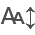

index          RA  e_RA_ICRS        DEC  e_DE_ICRS               MainID  \
0      112  150.136989     0.0732 -54.814744     0.0567  5260177293620497280   
1       29  150.168299     0.1350 -54.814701     0.1229  5260177117499592576   
2       20  150.145402     0.0753 -54.814339     0.0717  5260177083139830144   
3      128  150.140314     0.0323 -54.814120     0.0289  5260177293620498304   
4       84  150.138970     0.1631 -54.814002     0.1534  5260177293612371328   
..     ...         ...        ...        ...        ...                  ...   
341    433  150.148778     0.1610 -54.766102     0.1718  5260177809007373184   
342    423  150.148264     0.1852 -54.765770     0.2125  5260177809016603136   
343    447  150.173484     0.1778 -54.765659     0.1717  5260177843376348928   
344    307  150.189550     0.0201 -54.765288     0.0189  5260177637217924480   
345    444  150.169704     0.1186 -54.765028     0.1133  5260177839058642432   

        Plx   e_Plx    pmRA  e_pmRA  ...   BP-RP  RV  e_RV     Teff     AG  \
0    0.1150  0.0733  -6.209   0.139  ...  1.2742 NaN   NaN  4892.67    NaN   
1    0.4721  0.1541  -7.078   0.264  ...  1.6339 NaN   NaN      NaN    NaN   
2    0.2623  0.0885  -5.245   0.154  ...  1.3428 NaN   NaN  4707.00    NaN   
3    0.4682  0.0370  -6.800   0.063  ...  1.0331 NaN   NaN  5195.03    NaN   
4    0.3971  0.1925  -5.464   0.328  ...  1.4183 NaN   NaN      NaN    NaN   
..      ...     ...     ...     ...  ...     ...  ..   ...      ...    ...   
341  1.1779  0.2068  -5.719   0.344  ...  1.5448 NaN   NaN      NaN    NaN   
342  0.1246  0.2351  -6.686   0.415  ...     NaN NaN   NaN      NaN    NaN   
343 -0.2826  0.2062  -3.703   0.385  ...  1.7884 NaN   NaN      NaN    NaN   
344  1.0395  0.0226 -11.581   0.040  ...  0.9501 NaN   NaN  5408.00  0.328   
345  0.2228  0.1377  -4.168   0.248  ...  1.4613 NaN   NaN      NaN    NaN   

     E_BP-RP_   Rad    Lum  in_field  Weight  
0         NaN   NaN    NaN        IN       0  
1         NaN   NaN    NaN        IN       0  
2         NaN   NaN    NaN        IN       0  
3         NaN  1.82  2.184        IN       0  
4         NaN   NaN    NaN        IN       0  
..        ...   ...    ...       ...     ...  
341       NaN   NaN    NaN        IN       0  
342       NaN   NaN    NaN        IN       0  
343       NaN   NaN    NaN        IN       0  
344     0.159  1.18  1.073        IN       0  
345       NaN   NaN    NaN        IN       0  

[346 rows x 35 columns]

In [17]:
##### Activate the interactive mode for all series and dataframes with
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

main_pdtable["Weight"]=0
main_pdtable.to_csv(dir_name+"/table_to_be_ranked.csv")
main_pdtable

## Read the table back with, with the weigths

# First pass, on the top priority (weigth = 1)

In [18]:
main_pdtable_w = pd.read_csv(dir_name+"/table_to_be_ranked_w.csv")
column_names = main_pdtable_w.columns
print(column_names)
main_pdtable_w.drop('Unnamed: 0', axis=1, inplace=True)
main_pdtable_w.reset_index(drop=True)

#we can sort the table, weight first, then dec
main_pdtable_ranked  = main_pdtable_w.sort_values(by=['Weight','DEC'],ascending=[True, False])
main_pdtable_ranked.reset_index(drop=True, inplace=True)
main_pdtable_ranked['mask'] = -1
main_pdtable_ranked

Index(['Unnamed: 0', 'index', 'RA', 'e_RA_ICRS', 'DEC', 'e_DE_ICRS', 'MainID',
       'Plx', 'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'Dup', 'FG', 'e_FG',
       'Gmag', 'e_Gmag', 'FBP', 'e_FBP', 'BPmag', 'e_BPmag', 'FRP', 'e_FRP',
       'RPmag', 'e_RPmag', 'BP-RP', 'RV', 'e_RV', 'Teff', 'AG', 'E_BP-RP_',
       'Rad', 'Lum', 'in_field', 'Weight', 'Unnamed: 36', 'Unnamed: 37',
       'Unnamed: 38'],
      dtype='object')


index          RA  e_RA_ICRS        DEC  e_DE_ICRS        MainID     Plx  \
0      307  150.189550     0.0201 -54.765288     0.0189  5.260180e+18  1.0395   
1      448  150.169639     0.0411 -54.766371     0.0371  5.260180e+18  0.1385   
2      306  150.193269     0.0380 -54.768577     0.0334  5.260180e+18  0.7013   
3      408  150.142730     0.0160 -54.769086     0.0159  5.260180e+18  0.0988   
4      424  150.153837     0.0332 -54.769971     0.0379  5.260180e+18  0.0484   
..     ...         ...        ...        ...        ...           ...     ...   
341     64  150.163194     0.1748 -54.805010     0.1604  5.260180e+18  0.1680   
342    168  150.181447     0.1968 -54.808257     0.1767  5.260180e+18  0.2434   
343    126  150.135338     0.1809 -54.811907     0.1662  5.260180e+18  0.7571   
344    253  150.192909     0.4023 -54.812532     0.5014  5.260180e+18 -0.2366   
345     45  150.170679     0.1800 -54.813749     0.1620  5.260180e+18  0.3411   

      e_Plx    pmRA  e_pmRA  ...      AG  E_BP-RP_   Rad    Lum  in_field  \
0    0.0226 -11.581   0.040  ...  0.3280    0.1590  1.18  1.073        IN   
1    0.0474  -6.551   0.087  ...     NaN       NaN   NaN    NaN        IN   
2    0.0406  -7.242   0.079  ...  0.2287    0.1090  0.95  0.662        IN   
3    0.0191  -3.745   0.033  ...  0.4687    0.2173   NaN    NaN        IN   
4    0.0431  -4.159   0.073  ...     NaN       NaN   NaN    NaN        IN   
..      ...     ...     ...  ...     ...       ...   ...    ...       ...   
341  0.2039  -3.884   0.347  ...     NaN       NaN   NaN    NaN        IN   
342  0.2368  -4.354   0.389  ...     NaN       NaN   NaN    NaN        IN   
343  0.2105  -5.356   0.358  ...     NaN       NaN   NaN    NaN        IN   
344  0.4734  -3.723   0.728  ...     NaN       NaN   NaN    NaN        IN   
345  0.2061  -9.120   0.350  ...     NaN       NaN   NaN    NaN        IN   

     Weight  Unnamed: 36  Unnamed: 37  Unnamed: 38  mask  
0         1          NaN          NaN          NaN    -1  
1         1          NaN          NaN          NaN    -1  
2         1          NaN          NaN          NaN    -1  
3         1          NaN          NaN          NaN    -1  
4         1          NaN          NaN          NaN    -1  
..      ...          ...          ...          ...   ...  
341       5          NaN          NaN          NaN    -1  
342       5          NaN          NaN          NaN    -1  
343       5          NaN          NaN          NaN    -1  
344       5          NaN          NaN          NaN    -1  
345       5          NaN          NaN          NaN    -1  

[346 rows x 39 columns]

In [19]:
Slit_Width_pix = 3 #pixels; this affects the total nr. of spectra in a dense field
Slit_Length_pix = 9 #pixels; this affect the resolution of the spectra

In [20]:
#main_pdtable_ranked_Weigth1 = main_pdtable_ranked[(main_pdtable_ranked['Weight'] == 1) & (main_pdtable_ranked['mask'] == -1)]
#print(len(main_pdtable_ranked_Weigth1))


0 66 46 0 0
best at trial 0 :
nr in mask 0 66
nr in mask 1 0
nr in mask 2 0
nr in mask 2 0
nr in mask 2 0
2 67 46 66 46
best at trial 2 :
nr in mask 0 67
nr in mask 1 0
nr in mask 2 0
nr in mask 2 0
nr in mask 2 0
4 67 46 67 46
best at trial 4 :
nr in mask 0 67
nr in mask 1 0
nr in mask 2 0
nr in mask 2 0
nr in mask 2 0
8 68 46 67 46
best at trial 8 :
nr in mask 0 68
nr in mask 1 0
nr in mask 2 0
nr in mask 2 0
nr in mask 2 0
end of trial:
nr in mask 0 68
nr in mask 1 0
nr in mask 2 0
nr in mask 2 0
nr in mask 2 0


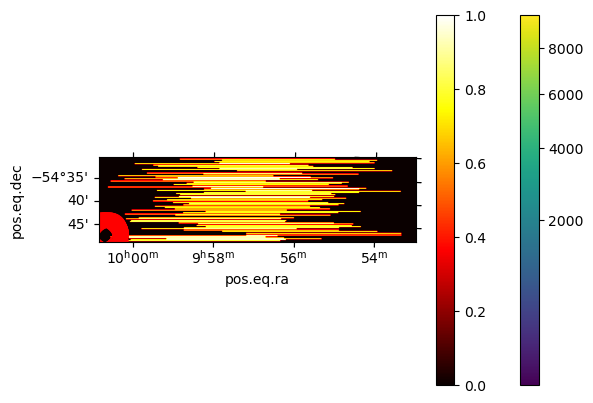

0 66 17 0 0
best at trial 0 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 0
nr in mask 2 0
nr in mask 2 0
1 66 17 66 17
best at trial 1 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 0
nr in mask 2 0
nr in mask 2 0
3 66 17 66 17
best at trial 3 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 0
nr in mask 2 0
nr in mask 2 0
4 66 17 66 17
best at trial 4 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 0
nr in mask 2 0
nr in mask 2 0
5 66 17 66 17
best at trial 5 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 0
nr in mask 2 0
nr in mask 2 0
7 66 17 66 17
best at trial 7 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 0
nr in mask 2 0
nr in mask 2 0
8 66 17 66 17
best at trial 8 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 0
nr in mask 2 0
nr in mask 2 0
9 66 17 66 17
best at trial 9 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 0
nr in mask 2 0
nr in mask 2 0
10 66 17 66 17
best at trial 10 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 0
nr in mask 2 0
nr in mask 2 0
11 66 17 66 17
best

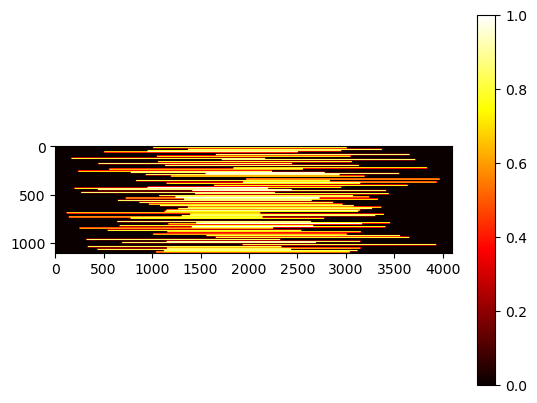

0 58 6 0 0
best at trial 0 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 58
nr in mask 2 0
nr in mask 2 0
1 58 6 58 6
best at trial 1 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 58
nr in mask 2 0
nr in mask 2 0
2 58 6 58 6
best at trial 2 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 58
nr in mask 2 0
nr in mask 2 0
3 58 6 58 6
best at trial 3 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 58
nr in mask 2 0
nr in mask 2 0
4 58 6 58 6
best at trial 4 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 58
nr in mask 2 0
nr in mask 2 0
5 58 6 58 6
best at trial 5 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 58
nr in mask 2 0
nr in mask 2 0
6 58 6 58 6
best at trial 6 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 58
nr in mask 2 0
nr in mask 2 0
7 58 6 58 6
best at trial 7 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 58
nr in mask 2 0
nr in mask 2 0
8 58 6 58 6
best at trial 8 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 58
nr in mask 2 0
nr in mask 2 0
9 58 6 58 6
best at trial 9 :

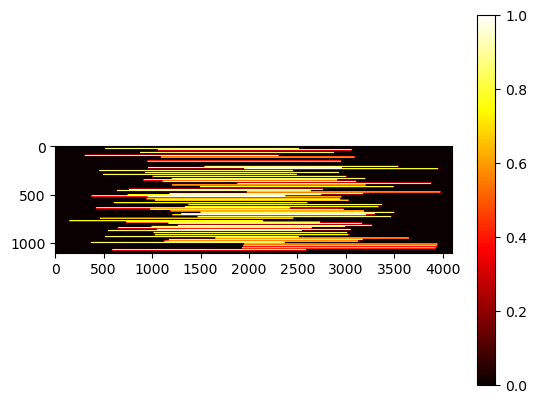

0 42 1 0 0
best at trial 0 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 58
nr in mask 2 42
nr in mask 2 0
1 42 1 42 1
best at trial 1 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 58
nr in mask 2 42
nr in mask 2 0
2 42 1 42 1
best at trial 2 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 58
nr in mask 2 42
nr in mask 2 0
3 42 1 42 1
best at trial 3 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 58
nr in mask 2 42
nr in mask 2 0
4 42 1 42 1
best at trial 4 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 58
nr in mask 2 42
nr in mask 2 0
5 42 1 42 1
best at trial 5 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 58
nr in mask 2 42
nr in mask 2 0
6 42 1 42 1
best at trial 6 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 58
nr in mask 2 42
nr in mask 2 0
7 42 1 42 1
best at trial 7 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 58
nr in mask 2 42
nr in mask 2 0
8 42 1 42 1
best at trial 8 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 58
nr in mask 2 42
nr in mask 2 0
9 42 1 42 1
best at 

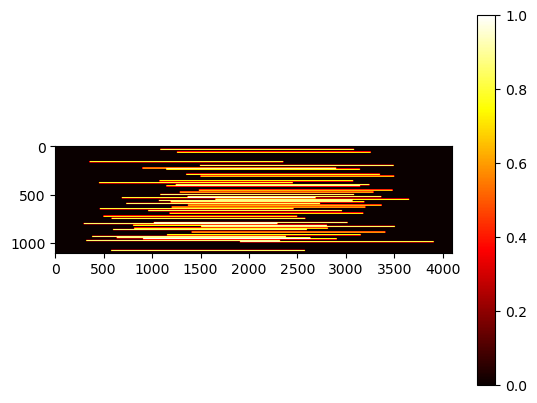

0 39 0 0 0
best at trial 0 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 58
nr in mask 2 42
nr in mask 2 39
1 39 0 39 0
best at trial 1 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 58
nr in mask 2 42
nr in mask 2 39
2 39 0 39 0
best at trial 2 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 58
nr in mask 2 42
nr in mask 2 39
3 39 0 39 0
best at trial 3 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 58
nr in mask 2 42
nr in mask 2 39
4 39 0 39 0
best at trial 4 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 58
nr in mask 2 42
nr in mask 2 39
5 39 0 39 0
best at trial 5 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 58
nr in mask 2 42
nr in mask 2 39
6 39 0 39 0
best at trial 6 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 58
nr in mask 2 42
nr in mask 2 39
7 39 0 39 0
best at trial 7 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 58
nr in mask 2 42
nr in mask 2 39
8 39 0 39 0
best at trial 8 :
nr in mask 0 68
nr in mask 1 66
nr in mask 2 58
nr in mask 2 42
nr in mask 2 39
9 39 0 39 0

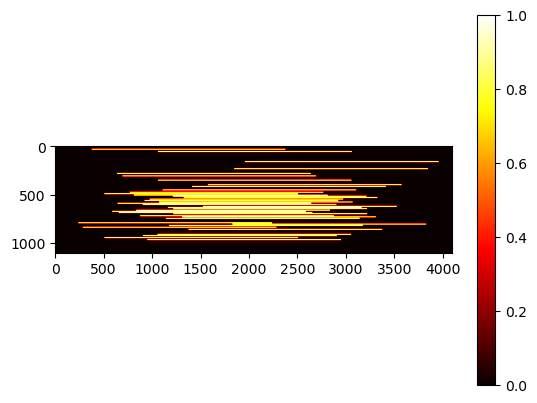

In [21]:
dataframe_collection = {}

for k in range(5): #first iteration to extract first region file
    #main_pdtable_ranked_Weigth1 = main_pdtable_ranked[(main_pdtable_ranked['Weight'] == 1) & (main_pdtable_ranked['mask'] == -1)]
    #print(len(main_pdtable_ranked_Weigth1)) #69 sources with Weight 1 entering the loop
    
    np.random.seed(42)
    best_rank1 = 0
    best_total = 0
    for i in range(20):
        rank1 = []
        total = []
        
        #make a copy of the big input table

        main_pdtable_ranked_internal = copy.deepcopy(main_pdtable_ranked) #346 elements
        #print('\nstarting with these masks data:')
        #print('nr of 0',len(main_pdtable_ranked_internal[main_pdtable_ranked_internal['mask']==0]))   
        #print('nr of 1',len(main_pdtable_ranked_internal[main_pdtable_ranked_internal['mask']==1]))
        #print('nr of 2',len(main_pdtable_ranked_internal[main_pdtable_ranked_internal['mask']==2]))
        #print(main_pdtable_ranked)
        
        N_ones = len(main_pdtable_ranked_internal[(main_pdtable_ranked_internal['Weight'] == 1) & (main_pdtable_ranked_internal['mask'] == -1)])
        #print('N_ones = ', N_ones)
        df = main_pdtable_ranked_internal[(main_pdtable_ranked_internal['Weight'] == 1) & (main_pdtable_ranked_internal['mask'] == -1)].sample(frac=1)
        #print(df)
        main_pdtable_ranked_internal = main_pdtable_ranked_internal.sort_values(by=['Weight','mask'],ascending=[True, True])
        main_pdtable_ranked_internal[:N_ones]=df
        #print(main_pdtable_ranked_internal)
        #print('nr of 0',len(main_pdtable_ranked_internal[main_pdtable_ranked_internal['mask']==0]))   
        #print('nr of 1',len(main_pdtable_ranked_internal[main_pdtable_ranked_internal['mask']==1]))
        #print('nr of 2',len(main_pdtable_ranked_internal[main_pdtable_ranked_internal['mask']==2]))
 
       
      
        xc = ((main_pdtable_ranked_internal['RA']-ra)*3600*6).astype(int)
        yc = ((main_pdtable_ranked_internal['DEC']-dec)*3600*6).astype(int)
        length=2000
        spacing = 2 #pixel
        source_separation = (Slit_Length_pix + spacing) #pixel
            
        #POPULATE FRAME
        fullarray = np.zeros((1100,4096))
        count0=0
        listone=[]
        for j in range(len(main_pdtable_ranked_internal)):
            #print(j,main_pdtable_ranked_internal.at[j,'index'])
            if main_pdtable_ranked_internal.at[j,'index'] == 34:
                count0 = count0+1
                #print(count0,main_pdtable_ranked_internal.at[j,'index'])
                listone.append(main_pdtable_ranked_internal.at[j,'index'])
                #print(listone)
            if main_pdtable_ranked_internal.at[j,'mask'] != -1:
                #print(main_pdtable_ranked_internal.iloc[j]['mask'])
                #print('skipping j: ', j)
                #print(main_pdtable_ranked_internal.iloc[j]['mask'])
                continue
            y0 = (yc[j]-int(source_separation/2)+550)
            y1 = (yc[j]+int(source_separation/2)+551)
            x0 = (xc[j]-int(length/2)+2048)
            x1 = (xc[j]+int(length/2)+2048)
            array = np.zeros((1100,4096))
            rectangle = np.ones((source_separation, length))
            array[y0:y1,x0:x1] = rectangle
            fullarray += array
            if np.max(fullarray) > 1:   #"OVERLAP: UNDO!"
                fullarray -= array #undo            
            else: #NO OVERLAP: GOOD"
                #keep track of the TARGETS
                if main_pdtable_ranked_internal.iloc[j]['Weight'] == 1:
                    rank1.append(j)
                #keep track of the total (FILLERS included)    
                total.append(j)   
                #promote the source to the current k-th mask
                #print('current mask:',main_pdtable_ranked_internal.at[j,'mask'])
                main_pdtable_ranked_internal.at[j,'mask'] = k
                #print('new   mask = ',main_pdtable_ranked_internal.at[j,'mask'])
                #print('check        ',main_pdtable_ranked_internal.at[j,'mask'])
                #df.at[1, 'B'] = 10
                #df[df['A'] > 2]['B']
        #print(i,len(total),len(rank1),best_total,best_rank1)        
         
        #plt.imshow(fullarray, cmap='hot')
        #plt.colorbar()
        #plt.show()
        
        #do we want to keep this iteration?
        if (len(rank1) >= best_rank1) and (len(total) >= best_total):
            print(i,len(total),len(rank1),best_total,best_rank1)
            best_rank1 = len(rank1)
            best_total = len(total)
            target_list_out = copy.deepcopy(main_pdtable_ranked_internal)
            #print('i_best = ', i)
            
            print('best at trial',i,':')
            print('nr in mask 0',len(target_list_out[target_list_out['mask']==0]))   
            print('nr in mask 1',len(target_list_out[target_list_out['mask']==1]))   
            print('nr in mask 2',len(target_list_out[target_list_out['mask']==2]))           
            print('nr in mask 2',len(target_list_out[target_list_out['mask']==3]))           
            print('nr in mask 2',len(target_list_out[target_list_out['mask']==4]))           
    print('end of trial:')        
    #print('nr in mask 0',len(target_list_out[target_list_out['mask']==0]))   
    #print('nr in mask 1',len(target_list_out[target_list_out['mask']==1]))   
    #print('nr in mask 2',len(target_list_out[target_list_out['mask']==2]))           

    print('nr in mask 0',len(main_pdtable_ranked_internal[main_pdtable_ranked_internal['mask']==0]))   
    print('nr in mask 1',len(main_pdtable_ranked_internal[main_pdtable_ranked_internal['mask']==1]))
    print('nr in mask 2',len(main_pdtable_ranked_internal[main_pdtable_ranked_internal['mask']==2]))
    print('nr in mask 2',len(main_pdtable_ranked_internal[main_pdtable_ranked_internal['mask']==3]))
    print('nr in mask 2',len(main_pdtable_ranked_internal[main_pdtable_ranked_internal['mask']==4]))
    main_pdtable_ranked = main_pdtable_ranked_internal    
    #print(len(main_pdtable_ranked[main_pdtable_ranked_internal['mask']==0]))   
    #print(len(main_pdtable_ranked[main_pdtable_ranked_internal['mask']==1]))

    #SORT BY DEC. From south (down) to north (up)
    main_pdtable_ranked_internal  = main_pdtable_ranked_internal.sort_values(by=['DEC'],ascending=[True])

    #SAVE .csv TABLE FILES
    main_pdtable_ranked_internal[main_pdtable_ranked_internal['mask']==k].to_csv(dir_name+"/table_ranked_"+str(k)+".csv")
    target_list_out.to_csv(dir_name+"/table_out.csv")

    dataframe_collection[k] = main_pdtable_ranked_internal[main_pdtable_ranked_internal['mask']==k]
    
    #target_list_out_Weigth1 = target_list_out[target_list_out['Weight'] == 1]
    #target_list_out_Weigth2 = target_list_out[target_list_out['Weight'] != 1]
    
    
    plt.imshow(fullarray, cmap='hot')
    plt.colorbar()
    plt.show()

In [22]:
main_pdtable_mask0 = pd.read_csv(dir_name+"/table_ranked_"+str(0)+".csv")
#main_pdtable_ranked_internal[main_pdtable_ranked_internal['mask']==0]
main_pdtable_mask1 = main_pdtable_ranked_internal[main_pdtable_ranked_internal['mask']==1]
main_pdtable_mask2 = main_pdtable_ranked_internal[main_pdtable_ranked_internal['mask']==2]
main_pdtable_mask3 = main_pdtable_ranked_internal[main_pdtable_ranked_internal['mask']==3]
main_pdtable_mask4 = main_pdtable_ranked_internal[main_pdtable_ranked_internal['mask']==4]
#target_list_out
main_pdtable_mask0

Unnamed: 0  index          RA  e_RA_ICRS        DEC  e_DE_ICRS  \
0          138    112  150.136989     0.0732 -54.814744     0.0567   
1           21    128  150.140314     0.0323 -54.814120     0.0289   
2           51     48  150.161574     0.0324 -54.813592     0.0296   
3          274    136  150.139223     0.1443 -54.813032     0.1330   
4          134     77  150.128186     0.0844 -54.812481     0.0789   
..         ...    ...         ...        ...        ...        ...   
63          52    306  150.193269     0.0380 -54.768577     0.0334   
64          69    312  150.190281     0.0704 -54.767830     0.0674   
65         212    308  150.194804     0.1455 -54.767074     0.1415   
66          60    448  150.169639     0.0411 -54.766371     0.0371   
67          59    307  150.189550     0.0201 -54.765288     0.0189   

          MainID     Plx   e_Plx    pmRA  ...      AG  E_BP-RP_   Rad    Lum  \
0   5.260180e+18  0.1150  0.0733  -6.209  ...     NaN       NaN   NaN    NaN   
1   5.260180e+18  0.4682  0.0370  -6.800  ...     NaN       NaN  1.82  2.184   
2   5.260180e+18  0.2873  0.0381  -7.221  ...  1.8450    0.8825   NaN    NaN   
3   5.260180e+18  0.1586  0.1699  -3.950  ...     NaN       NaN   NaN    NaN   
4   5.260180e+18  0.1155  0.0972  -4.738  ...     NaN       NaN   NaN    NaN   
..           ...     ...     ...     ...  ...     ...       ...   ...    ...   
63  5.260180e+18  0.7013  0.0406  -7.242  ...  0.2287    0.1090  0.95  0.662   
64  5.260180e+18  0.0917  0.0791  -4.799  ...     NaN       NaN   NaN    NaN   
65  5.260180e+18  0.2142  0.1571  -4.057  ...     NaN       NaN   NaN    NaN   
66  5.260180e+18  0.1385  0.0474  -6.551  ...     NaN       NaN   NaN    NaN   
67  5.260180e+18  1.0395  0.0226 -11.581  ...  0.3280    0.1590  1.18  1.073   

    in_field  Weight  Unnamed: 36  Unnamed: 37  Unnamed: 38  mask  
0         IN       2          NaN          NaN    50.265482     0  
1         IN       1          NaN          NaN          NaN     0  
2         IN       1          NaN          NaN          NaN     0  
3         IN       4          NaN          NaN          NaN     0  
4         IN       2          NaN          NaN          NaN     0  
..       ...     ...          ...          ...          ...   ...  
63        IN       1          NaN          NaN          NaN     0  
64        IN       2          NaN          NaN          NaN     0  
65        IN       4          NaN          NaN          NaN     0  
66        IN       1          NaN          NaN          NaN     0  
67        IN       1          NaN          NaN          NaN     0  

[68 rows x 40 columns]

In [23]:
aladin = Aladin(
    layout=Layout(width="50%"),
    target=Target_name,
    fov=0.2,
    survey='P/2MASS/color',
    show_projection_control=False,
    show_fullscreen_control=False,
)
aladin

Aladin(layout=Layout(width='50%'), survey='P/2MASS/color')

In [24]:
#then overplot
overplot_table = main_pdtable_mask0
#aladin.add_table(main_ap_table)
#FILLERS = target_list_out_Weigth2
aladin.add_table(Table.from_pandas(overplot_table[overplot_table['Weight']!=1]),color="YELLOW")
#TARGETS = target_list_out_Weigth1.iloc[slit_list_1]
aladin.add_table(Table.from_pandas(overplot_table[overplot_table['Weight']==1]),color="RED")
#print("there are ",len(main_pdtable_sorted)," sources")

In [25]:
#for i in range(len(main_pdtable_sorted)):
#    print(i,main_pdtable_sorted.iloc[i]['DEC']*3600- main_pdtable_sorted.iloc[i+1]['DEC']*3600,slit_length_as)

# GAIA DR3 Teff is always needed

In [26]:
#width of the field in "tangent arcminutes"
#The 3'x3' field corresponds to RA range that depends on the DEC. 
#If the Width is DRA=3' arcmin at the equator, at the source this corresponds to DRA=3/cos(delta).  
dra = 3.3/np.cos(Posy*u.deg)
print(dra.value)

Gaia.ROW_LIMIT = -1
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"  # Reselect Data Release 3, default
#from astropy.coordinates import SkyCoord


coord = SkyCoord(ra=Posx, dec=Posy, unit=(u.degree, u.degree), frame='icrs')
width = u.Quantity(dra.value, u.arcmin)
height = u.Quantity(3.3, u.arcmin)
r_Gaia = Gaia.query_object_async(coordinate=coord, width=width, height=height)
#INFO: Query finished. [astroquery.utils.tap.core]
r_Gaia.pprint(max_lines=12, max_width=130)

print("\n\n FOUND ", len(r_Gaia), " GAIA DR3 SOURCES")

5.723453883855327
INFO: Query finished. [astroquery.utils.tap.core]
         dist             solution_id             DESIGNATION          ... ebpminrp_gspphot_upper libname_gspphot
                                                                       ...          mag                          
--------------------- ------------------- ---------------------------- ... ---------------------- ---------------
0.0005742871855936325 1636148068921376768 Gaia DR3 5260177499778946688 ...                 0.5139           MARCS
0.0005759697823036589 1636148068921376768 Gaia DR3 5260177495457182464 ...                 1.0508           MARCS
0.0007914742200934706 1636148068921376768 Gaia DR3 5260177499769684992 ...                 1.3807               A
                  ...                 ...                          ... ...                    ...             ...
  0.03607456398229854 1636148068921376768 Gaia DR3 5260176675139312128 ...                     --                
 0.03626541659417234

In [27]:
aladin = Aladin(
    layout=Layout(width="50%"),
    target=Target_name,
    fov=0.2,
    survey='P/2MASS/color',
    show_projection_control=False,
    show_fullscreen_control=False,
)
aladin

Aladin(layout=Layout(width='50%'), survey='P/2MASS/color')

In [28]:


#then overplot
aladin.add_table(r_Gaia)

print("there are ",len(r_Gaia)," sources")

gaia_pdtable = r_Gaia.to_pandas()
gaia_pdtable_sorted  = gaia_pdtable.sort_values(by=['teff_gspphot'])
gaia_pdtable_sorted['rank']="FILLER"

gaia_pdtable_sorted.loc[gaia_pdtable_sorted['teff_gspphot'] > 5000,"rank"] = "TARGET" 
#gaia_pdtable_sorted
TARGETS = gaia_pdtable_sorted.loc[gaia_pdtable_sorted['rank'] == "TARGET"]
aladin.add_table(Table.from_pandas(TARGETS),color="red")
FILLERS = gaia_pdtable_sorted.loc[gaia_pdtable_sorted['rank'] == "FILLER"]
aladin.add_table(Table.from_pandas(FILLERS),color="yellow")
print("there are ",len(TARGETS)," targets, shown in red")
print("there are ",len(FILLERS)," fillers, shown in yellow")

there are  1042  sources
there are  171  targets, shown in red
there are  871  fillers, shown in yellow


# Other ranking example: USING THE SKYMAPPER CATALOG

# PICK-UP YOUR TABLE WITH TARGETS AND FILLERS!

In [29]:
%%script false --no-raise-error

#import copy
panda_targetlist = copy.deepcopy(main_pdtable_mask0)
#panda_targetlist = copy.deepcopy(gaia_pdtable_sorted)
#panda_targetlist = copy.deepcopy(skymapper_pandas_sorted)v

### Default slit width

In [30]:
%%script false --no-raise-error

panda_targetlist['slit_width']=Slit_Width_pix
panda_targetlist['slit_length']=Slit_Length_pix
panda_targetlist.set_index('index')

In [31]:
%%script false --no-raise-error

#COMMENT THE LINE ABOVE TO RUN
#==================================

CRITERIA = "DEC"
pandacat_4p2_decsorted = pandacat_4p1
pandacat_4p2_decsorted

#SET SLITS
pandacat_4p2_decsorted['ymax']=pandacat_4p2_decsorted['DEC']+pandacat_4p2_decsorted['slit_length']/3600.*0.18/2
pandacat_4p2_decsorted['ymin']=pandacat_4p2_decsorted['DEC']-pandacat_4p2_decsorted['slit_length']/3600.*0.18/2
pandacat_4p2_decsorted

#CHECK OVERLAPS
#print(panda_targetlist_4p2_sorted['ymin'],panda_targetlist_4p2_sorted['DEC'],panda_targetlist_4p2_sorted['ymax'])
for i in range(1,len(pandacat_4p2_decsorted['DEC'])):  #skip the first entry, that would check against 0
    if pandacat_4p2_decsorted['good'].iloc[i] == 0:
        continue
    #print('\n',i,pandacat_4p2_decsorted['ymin'].iloc[i],
          #panda_targetlist_4p2_sorted['DEC'][i])##,
    #      pandacat_4p2_decsorted['ymax'].iloc[i])
    for j in range(0,i):
        if pandacat_4p2_decsorted['good'].iloc[j] == 0:
            continue
    #    print(j,pandacat_4p2_decsorted['ymin'].iloc[j],pandacat_4p2_decsorted['ymax'].iloc[j])
        if ( (pandacat_4p2_decsorted['good'].iloc[i] == 1) and
             (pandacat_4p2_decsorted['ymax'].iloc[i] > pandacat_4p2_decsorted['ymin'].iloc[j]) and
             (pandacat_4p2_decsorted['ymin'].iloc[i] < pandacat_4p2_decsorted['ymax'].iloc[j]) ):
            pandacat_4p2_decsorted.loc[i,'good'] = 0
            print(i, 'is bad as it conflicts with', j) 
            continue
     #   else:
     #       print('good')

#DOWNSELECT THE NON OVERLAPPING
panda_targetlist_4p2_decsorted_final = pandacat_4p2_decsorted[pandacat_4p2_decsorted['good'] > 0]
panda_targetlist_4p2_decsorted_final

#DISPLAY
print("there are ",len(panda_targetlist_4p2_decsorted_final)," sources")
#pandacat_4p1.head
ax = plt.subplot(projection=wcs)
ax.invert_xaxis()
ax.invert_yaxis()
ax.imshow(hdu.data, vmin=zmin+zrange/1000, vmax=zmin+zrange*0.01)#, origin='lower')
ax.scatter(panda_targetlist_4p2_decsorted_final.RA, panda_targetlist_4p2_decsorted_final.DEC, transform=ax.get_transform('fk5'), s=300,
           edgecolor='yellow', facecolor='none')

# SAVE the list of selected targets as Simbad regions file

In [32]:
def Simbad_table_2_Astropy_slitregions(it,pdtab, dir_name=None, filename=None):

    #pdtab = SimbadTable.to_pandas()
    #print(pdtab['RA'],pdtab['DEC'])
    # Determine the RADEC offset in degrees
    RA_Center = ra#np.mean(pdtab['RA'])
    DEC_Center = dec#np.mean(pdtab['DEC'])
#    RA_Offsets = AstropyTable['RA'] - RA_Center
#    DEC_Offsets = AstropyTable['DEC'] - DEC_Center
#    print(np.c_[RA_Offsets[0:5], DEC_Offsets[0:5]]) #in degrees
    
    positions=[]
    for i in range(len(pdtab['RA'])):
        positions.append( (pdtab['RA'].iloc[i],pdtab['DEC'].iloc[i]) )

    coords =[SkyCoord(x,y, unit=(u.hourangle,u.deg), frame='fk5').to_string('decimal') for x,y in positions]
    #print(coords)
    
#    RA_i=[]
#    DEC_i=[]
#    for i in range(len(coords)):
#        ra,dec= coords[i].split(' ')
#        RA_i.append(float(ra))
#        DEC_i.append(float(dec))
#    #print(RA_i,"\n",DEC_i)           
#    RA_Center = np.mean(RA_i)
#    DEC_Center = np.mean(DEC_i)
#    #print(RA_Center, DEC_Center)
        

    apregions = [RectangleSkyRegion(center=SkyCoord(x,y, unit=(u.hourangle, u.degree), frame='fk5'),#unit='deg', frame='fk5'),
                                  width=0.18*Slit_Width_pix * u.arcsec, height=0.18* Slit_Length_pix * u.arcsec,
                                  angle=0 * u.deg) for x,y in positions]
    slits = Regions(apregions)
    #print(slits[0])

    if filename is None:
        filename = Target_name+"-T"+"{:02d}".format(it)+"_RADEC="+str(round(RA_Center,7))+ '{0:+}'.format(round(DEC_Center,7))
#    filename = Target+"_RADEC="+str(round(RA_Center,7))+ '{0:+}'.format(round(DEC_Center,7))+".reg"
#    '{0:+} number'.format(1)
    slits.write(dir_name+"/"+filename+".reg",overwrite=True, format='ds9')
    pdtab.to_csv(dir_name+"/"+filename+".csv")
     
    print("\nSlits written to region file\n",filename)
    return slits 

## HERE WE GO
## ================


#RUN
Nr_of_tables = len(dataframe_collection)
print(Nr_of_tables)
for it in range(Nr_of_tables):
    slits = Simbad_table_2_Astropy_slitregions(it,dataframe_collection[it], dir_name, filename=None)   
    print(dir_name,filename)

5

Slits written to region file
 AM 0958-543-T00_RADEC=150.17-54.79
/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA/RUN2/Science_targets/AM 0958-543 AM 0958-543_slits.reg

Slits written to region file
 AM 0958-543-T01_RADEC=150.17-54.79
/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA/RUN2/Science_targets/AM 0958-543 AM 0958-543_slits.reg

Slits written to region file
 AM 0958-543-T02_RADEC=150.17-54.79
/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA/RUN2/Science_targets/AM 0958-543 AM 0958-543_slits.reg

Slits written to region file
 AM 0958-543-T03_RADEC=150.17-54.79
/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA/RUN2/Science_targets/AM 0958-543 AM 0958-543_slits.reg

Slits

## For calibration at the telescope, save the even and the odd lists

In [33]:
#RUN_even
for it in range(Nr_of_tables):
    print(it)
    filename = Target_name+"-T"+"{:02d}".format(it)+"_even_RADEC="+str(round(ra,7))+ '{0:+}'.format(round(dec,7))
    slits = Simbad_table_2_Astropy_slitregions(it,dataframe_collection[it].iloc[::2], dir_name, filename) 
    print(dir_name,filename)

for it in range(Nr_of_tables):
    print(it)
    filename = Target_name+"-T"+"{:02d}".format(it)+"_odd_RADEC="+str(round(ra,7))+ '{0:+}'.format(round(dec,7))
    slits = Simbad_table_2_Astropy_slitregions(it,dataframe_collection[it].iloc[::2], dir_name, filename) 
    print(dir_name,filename)

0

Slits written to region file
 AM 0958-543-T00_even_RADEC=150.17-54.79
/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA/RUN2/Science_targets/AM 0958-543 AM 0958-543-T00_even_RADEC=150.17-54.79
1

Slits written to region file
 AM 0958-543-T01_even_RADEC=150.17-54.79
/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA/RUN2/Science_targets/AM 0958-543 AM 0958-543-T01_even_RADEC=150.17-54.79
2

Slits written to region file
 AM 0958-543-T02_even_RADEC=150.17-54.79
/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA/RUN2/Science_targets/AM 0958-543 AM 0958-543-T02_even_RADEC=150.17-54.79
3

Slits written to region file
 AM 0958-543-T03_even_RADEC=150.17-54.79
/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_H

# NOW SOME FUN WITH GRAPHICS

## 1) # Find the RADEC Center of the group of stars. This is where we should point SAMOS

## The next steps are preliminar and just an example of the process

The conversion from RADEC to DMDs will require a numbe of steps:

1) Ideally we would like to know where each DMD mirror is located on the sky. In this way we could directly set the DMD without using the imaging channel. This requires a lot of calibration:
    - Where is the center of the DMD field of view (x,y) vs. RADEC (telescope pointing), i.e. where SAMOS is pointing.
    - What is the possible rotation of the DMD field of view vs. RADEC (SAMOS setup)
    - What is the scale factor, and other information for astrometry that we put in the FITS header.
        THIS WILL REQUIRE SOME PREPARATORY WORK.
        See for example https://fits.gsfc.nasa.gov/fits_wcs.html
                        http://casu.ast.cam.ac.uk/surveys-projects/wfcam/technical/astrometry
                
2) If we miss some of these information, we need to acquire the targets using the imaging channel
    - Point the telescope to the target and take image
    - Determine astrometric solution of the image, using GAIA stars (or other catalogs) and WCS parameters of the imager
    - From RADEC of the targets, determine (x,y) on the image
    - Using the image<->tranformation matrix, determine (x,y) on the DMD.
    

In [34]:
#Select a table in the collection
it = 0

# Determine the RADEC offset in degrees
RA_Center = np.mean(dataframe_collection[it]['RA'])
DEC_Center = np.mean(dataframe_collection[it]['DEC'])
RA_Offsets = dataframe_collection[it]['RA'] - RA_Center
DEC_Offsets = dataframe_collection[it]['DEC'] - DEC_Center
print(np.c_[RA_Offsets[0:5], DEC_Offsets[0:5]]) #in degrees

[[-0.02838083 -0.02469147]
 [-0.02505613 -0.02406738]
 [-0.00379573 -0.02354009]
 [-0.02614673 -0.02297965]
 [-0.03718453 -0.02242875]]


In [35]:
# Determine the RADEC offset in arcsec
RA_Offsets *= 3600
DEC_Offsets *= 3600
print(np.c_[RA_Offsets[0:5], DEC_Offsets[0:5]])   #in arcsec

[[-102.17099118  -88.88928776]
 [ -90.20207118  -86.64256376]
 [ -13.66463118  -84.74431976]
 [ -94.12823118  -82.72673576]
 [-133.86431118  -80.74349576]]


In [36]:
#Determine the RADEC position in SAMOS CCD pixels [1024,1024]
IM_CCD_Scale = 0.18
#
RA_Offsets_IMpix = RA_Offsets / IM_CCD_Scale # in pixels
DEC_Offsets_IMpix = DEC_Offsets / IM_CCD_Scale
print(np.c_[RA_Offsets_IMpix[0:5], DEC_Offsets_IMpix[0:5]])   #in pixels

[[-567.61661765 -493.82937647]
 [-501.12261765 -481.34757647]
 [ -75.91461765 -470.80177647]
 [-522.93461765 -459.59297647]
 [-743.69061765 -448.57497647]]


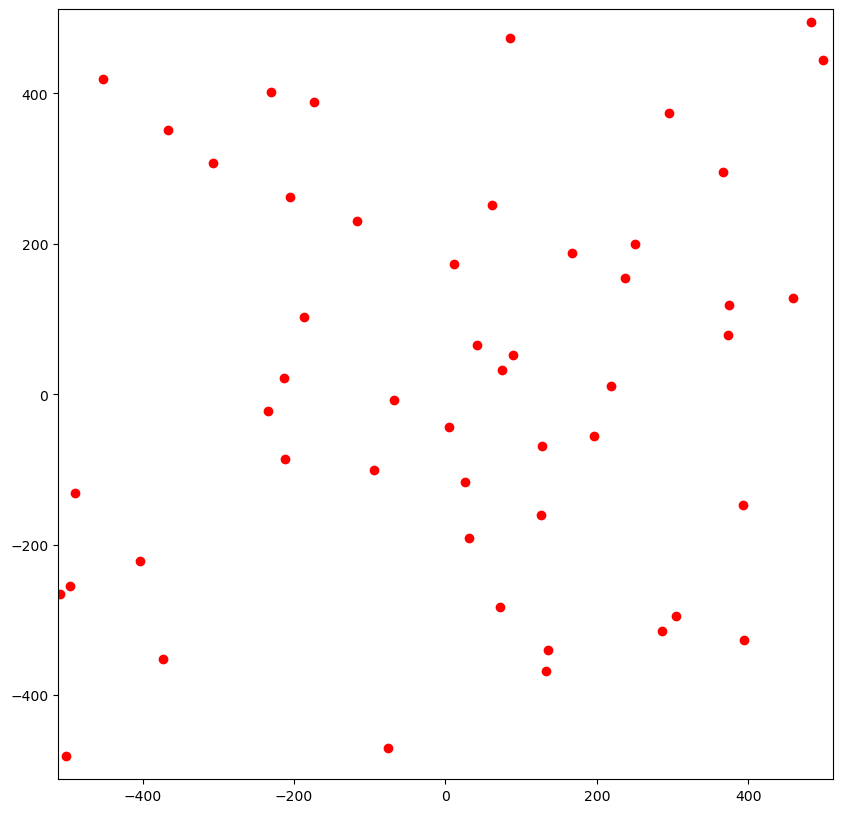

In [37]:
# Display sources in SAMOS Spectral Inst. CCD coordinates

%matplotlib inline
plt.figure(figsize=(10,10))
plt.plot(RA_Offsets_IMpix, DEC_Offsets_IMpix, 'ro')
plt.axis([-512, 512, -512, 512])
plt.show()

In [38]:
# OFFsets in in SAMI pixels (SAMOS-SP Channel)
SP_CCD_Scale = 0.133
#
RA_Offsets_SPpix = RA_Offsets / SP_CCD_Scale # in pixels
DEC_Offsets_SPpix = DEC_Offsets / SP_CCD_Scale
print(np.c_[RA_Offsets_SPpix[0:5], DEC_Offsets_SPpix[0:5]])

# OFFsets in in SpecIns pixels (SAMOS-IM Channel)
IM_CCD_Scale = 0.17578125 #180/1024
#
RA_Offsets_IMpix = RA_Offsets / IM_CCD_Scale # in pixels
DEC_Offsets_IMpix = DEC_Offsets / IM_CCD_Scale
print(np.c_[RA_Offsets_IMpix[0:5], DEC_Offsets_IMpix[0:5]])


[[ -768.20294118  -668.34050951]
 [ -678.21106148  -651.44784785]
 [ -102.74158779  -637.17533658]
 [ -707.73106148  -622.00553207]
 [-1006.49858027  -607.09395312]]
[[-581.23941647 -505.68128151]
 [-513.14956047 -492.89991831]
 [ -77.73656847 -482.10101911]
 [-535.48504847 -470.62320791]
 [-761.53919247 -459.34077591]]


##  Display the sources in a) the Spectral Instrument,  and b) the SAMI/SAMOS field of view, assumed centered in the CCD field, assumed centered in the middle of the 4098x4098 detector

<Figure size 1000x300 with 0 Axes>

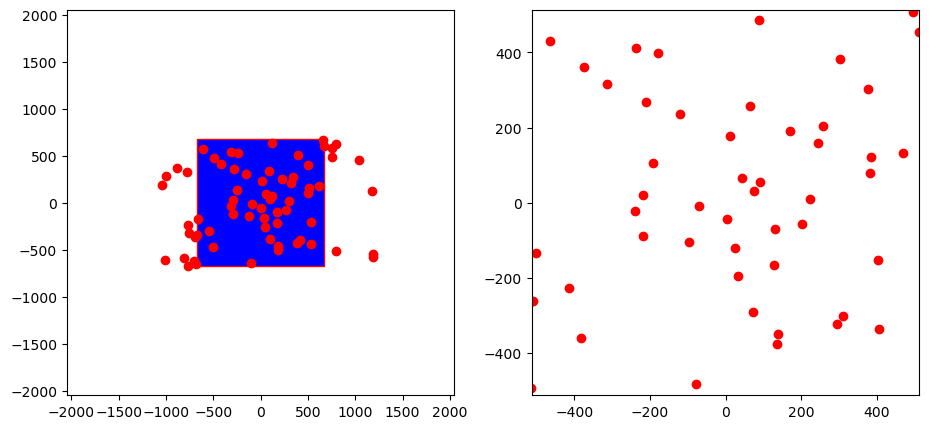

In [39]:
#import matplotlib.pyplot as plt
#import matplotlib.patches as patches
#%matplotlib inline
f = plt.figure(figsize=(10,3))
x1,x2=plt.subplots(1, 2, figsize=(11,5))
x1=plt.subplot(1, 2, 1)
x1.plot(RA_Offsets_SPpix, DEC_Offsets_SPpix, 'ro')
x1.axis([-2048, 2048, -2048, 2048])
rectangle = plt.Rectangle((-675,-675),1350, 1350, fc='blue',ec="red")
plt.gca().add_patch(rectangle)

x2=plt.subplot(1, 2, 2)
x2.plot(RA_Offsets_IMpix, DEC_Offsets_IMpix, 'ro')
x2.axis([-512, 512, -512, 512])

plt.show()


## Display the trace of the spectra in SAMI/SAMOS field of view, assumed 2000 pixels long.

/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA/RUN2/Science_targets/AM 0958-543/AM 0958-543-T00_slits.png


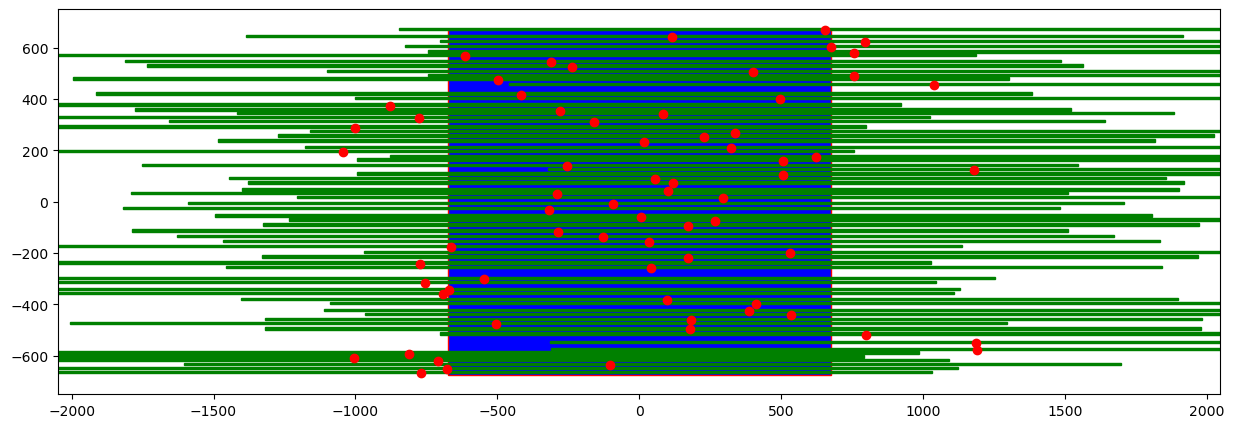

In [40]:
#import matplotlib.pyplot as plt
#import matplotlib.patches as patches
plt.figure(figsize=(15,5))
plt.plot(RA_Offsets_SPpix, DEC_Offsets_SPpix, 'ro')
plt.axis([-2048, 2048, -750, 750])
rectangle = plt.Rectangle((-675,-675),1350, 1350, fc='blue',ec="red")
plt.gca().add_patch(rectangle)
for i in range(len(RA_Offsets_IMpix)):
#    print(RA_Offsets_IMpix.iloc[i])
#    print(np.round(RA_Offsets_IMpix.iloc[i]-1),np.round(DEC_Offsets_IMpix.iloc[i]-1000,3, np.round(DEC_Offsets_IMpix.iloc[i]+1000))
    xy = (RA_Offsets_SPpix.iloc[i]-1500,np.round(DEC_Offsets_SPpix.iloc[i]))
    rectangle = plt.Rectangle(xy ,3300, 9, fc='green',ec="green")
    plt.gca().add_patch(rectangle)


#do you reallhy want to save these plots?
fileout= os.path.join(cwd, Target_name, Target_name+"-T"+"{:02d}".format(it)+'_slits.png')
print(fileout)
plt.savefig(fileout)
plt.show()

# GUIDE STARS

Given the rotation of the field, compensated adding an offset to the rotator, guide Stars must be searched in advance. We will use GAIA coordinates.

From R. Barkhouser e-mail, June 10, 2024: 

"From what I can determine, there is a $$34.5^\circ$$ rotation between the SAM and SAMOS field orientations.  I think that matches up (within 0.5 deg) to the 124 deg rotation you found for the x-flipped field (90 deg + 34 deg).  See attached..."

In [41]:
Angle = -34.5*u.deg

In [42]:
#import shutil
#import tempfile#import urllib.request
#from astropy.io import fits
#from astropy.wcs import WCS

# SOUTHERN HEMISPHERE: USE SKY MAPPER IMAGE

string="https://api.skymapper.nci.org.au/public/siap/dr4/get_image?IMAGE=20140425124821-10&SIZE=0.0833&POS=189.99763,-11.62305"

target_url = string
hdu = fits.open(target_url)[0]
wcs = WCS(hdu.header)
wcs

In [43]:
#loop over the images to get the first one with the minimum distance
mini = d_from_center[0]
i_mini = 0
for i in range(len(im_table)):
#    print(i,d_from_center[i],mini)
    if d_from_center[i] < mini:
        mini = d_from_center[i]
        i_mini=i
#print(i_mini)
#print(im_table[i_mini].getdataurl())


In [44]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Feb 19 22:05:04 2023

@author: robberto
"""
#import urllib.request
#import shutil
#import tempfile#import urllib.request
#from astropy.io import fits


def skymapper_interrogate(POSx=189.99763, POSy=-11.62305, RA_Size=1058, DEC_Size=1032, filter='r'):
    POS = str(POSx)+","+str(POSy)   #"189.99763,-11.62305"
   # Sizex = np.round(0.18 / 3600 * RA_Size, 6)
   # Sizey = np.round(0.18 / 3600 * DEC_Size, 6)
    Sizex = 0.18 / 3600 * RA_Size
    Sizey = 0.18 / 3600 * DEC_Size
    SIZE = str(Sizex) + "," + str(Sizey)  #"0.05,0.1"
    FILTERS  = filter  #"g"#"g,r,i"
    string0= 'https://api.skymapper.nci.org.au/public/siap/dr2/'
    string = string0 + "query?"
    string += 'POS=' + POS + '&'
    string += 'SIZE=' + '0.05' + '&'   # first call to find the plate we use a small 5'x5' field
    string += 'BAND=' + FILTERS + '&'
    string += 'FORMAT=image/fits&INTERSECT=covers'#'&MJD_END=56970'#'&RESPONSEFORMAT=CSV'
    
    with urllib.request.urlopen(string,timeout=30) as response:
       html = response.read()
    #print(html)
    
    #v=pd.read_csv(html)
    v=html.decode('UTF-8')
    
    #entrypoint  = v.find("\nSkyMapper")   #use this if &RESPONSEFORMAT=CSV' works
    #image_number = v[entrypoint+13:entrypoint+30]
 
    entrypoint = []
    [entrypoint.append(m.start()) for m in re.finditer(">SkyMapper_", v)] 

    min_d = 100.
    i_min_d = 0
    best_image = ""

    for i in range(len(entrypoint)):
    #    entrypoint_old  = v.find(">SkyMapper_")
        image_number = v[entrypoint[i]+13:entrypoint[i]+30]
        #print("a",entrypoint,image_number)
        
        string = string0 + "get_image?"
        string += 'IMAGE='+image_number + '&'
        string += 'SIZE=' + SIZE + '&'
        string += 'POS=' + POS + '&'
        string += 'BAND=' + FILTERS + '&'
        string += 'FORMAT=fits'

        Sizex = 0.18 / 3600 * 1058
        Sizey = 0.18 / 3600 * 1038
        SIZE_SAMOS = str(Sizex) + "," + str(Sizey)  #"0.05,0.1"
        string_SAMOS = string0 + "get_image?"
        string_SAMOS += 'IMAGE='+image_number + '&'
        string_SAMOS += 'SIZE=' + SIZE_SAMOS + '&'
        string_SAMOS += 'POS=' + POS + '&'
        string_SAMOS += 'BAND=' + FILTERS + '&'
        string_SAMOS += 'FORMAT=fits'
        
        #print(string)
        #print(string_SAMOS)
        
        #https://api.skymapper.nci.org.au/public/siap/dr2/get_image?IMAGE=20140425124821-10&SIZE=0.05,0.1&POS=189.99763,-11.62305&BAND=g&FORMAT=fits
        #https://api.skymapper.nci.org.au/public/siap/dr2/get_image?IMAGE=20140425124821-10&SIZE=0.0833&POS=189.99763,-11.62305&FORMAT=png
        #string='https://api.skymapper.nci.org.au/public/siap/dr2/query?POS=150.17110,-54.79004&SIZE=0.052899999999999996,0.05159999999999999&BAND=i&FORMAT=image/fits&INTERSECT=covers&MJD_END=56970'
        """
        #Fetching URLs
        #FROM https://docs.python.org/3/howto/urllib2.html
        """
        
        with urllib.request.urlopen(string,timeout=30) as response:
            #print("a")
            with tempfile.NamedTemporaryFile(delete=False) as tmp_file:
            #    print("b")
                shutil.copyfileobj(response, tmp_file)
        with open(tmp_file.name) as html:
            #print("c")
            pass
            
        with urllib.request.urlopen(string_SAMOS,timeout=30) as response_SAMOS:
            #print("d")
            with tempfile.NamedTemporaryFile(delete=False) as tmp_file_SAMOS:
            #    print("e")
                shutil.copyfileobj(response_SAMOS, tmp_file_SAMOS)
        with open(tmp_file_SAMOS.name) as html:
            #print("f")
            pass
        
        
        hdu_in = fits.open(tmp_file.name)
        header = hdu_in[0].header
        #print(header)
        NAXIS1 = header['NAXIS1']
        NAXIS2 = header['NAXIS2']
        #import astropy.wcs as wcs
        #mywcs = wcs.WCS(header)
        mywcs = WCS(header)
        ra_center_skymapper, dec_center_skymapper = mywcs.all_pix2world([[NAXIS1/2,NAXIS2/2]], 0)[0]
        # Locate and download an image of interest
        #There are multiple images, we want to take the one that is centered closed to our target to get full field coverage
        #calculate the distances from tall the center images
        print(ra_center_skymapper,Posx,np.cos(dec_center_skymapper*u.deg),dec_center_skymapper,Posy)
        d_from_center= np.sqrt( ( (ra_center_skymapper-Posx)/np.cos(dec_center_skymapper*u.deg))**2 +
                        (dec_center_skymapper-Posy)**2 )
        #check:
        #print(d_from_center)
        #print(best_image)
        if d_from_center < min_d:
            min_d = d_from_center
            i_min_d=i
            best_image=tmp_file
            best_image_SAMOS = tmp_file_SAMOS
            print(best_image_SAMOS)


        #data = hdu_in[0].data
        
        #import astropy.wcs as wcs
        #mywcs = wcs.WCS(header)
        #ra, dec = mywcs.all_pix2world([[data.shape[0]/2,data.shape[1]/2]], 0)[0]
        #header['RA'] = ra
        #header['DEC'] = dec
        #fits.writeto(tmp_file, data, header=header, overwrite=True)
    #print(best_image.name)
    #print(best_image_SAMOS.name)
    SkyMapper_query(best_image_SAMOS)
    if ((RA_Size == 1058) and (DEC_Size == 1032)) or ((RA_Size == 2560) and (DEC_Size == 2560)):
        return(best_image)
    elif np.absolute(header['NAXIS1'] - header['NAXIS2']) <= 1:
        return(best_image)
        
#    from astropy.io import fits
#    hdu = fits.open(tmp_file.name)[0]
#    image = hdu.data
#    header = hdu.header
#    return(hdu)
"""
    Inject image from SkyMapper to create a WCS solution using twirl
    """

def SkyMapper_query(filepath):
    print("enter here")
    """ get image from SkyMapper """
    #print("aa",filepath.name)

    #img = AstroImage()
    #Posx = str(radec_center.ra.value[0])
    #Posy = str(radec_center.dec.value[0])
    #filt ="g"
    #filepath = skymapper_interrogate(Posx, Posy, 1058, 1032, filt)
    # filepath = skymapper_interrogate_VOTABLE(Posx, Posy, filt)
    hdu_in = fits.open(filepath.name)
    #            img.load_hdu(hdu_in[0])
    data = hdu_in[0].data
    from PIL import Image
    image_data = Image.fromarray(data)
    img_res = image_data.resize(size=(1032, 1056))
    hdu_res = fits.PrimaryHDU(img_res)
        # ra, dec in degrees
    
    #ra = str(Posx)
    #dec = str(Posy)
    #hdu_res.header['RA'] = str(Posx)
    #hdu_res.header['DEC'] = Posy

    output_header = copy.deepcopy(hdu_res.header) # copy.deepcopy(hdu_in[0].header)
        #main_fits_header.add_astrometric_fits_keywords(hdu_res.header)
        #            rebinned_filename = "./SkyMapper_g_20140408104645-29_150.171-54.790_1056x1032.fits"
        #           hdu.writeto(rebinned_filename,overwrite=True)
        
    #    output_header['RA'] = ra
    #    output_header['DEC'] = dec
    output_header['WCSAXES'] = 2 #/ Number of coordinate axes       
    output_header['NAXIS1'] = float(1056)
    output_header['NAXIS2'] = float(1032)
    output_header['CRVAL1'] = str(Posx)
    output_header['CRVAL2'] = Posy
    output_header['CRPIX1'] = float(528)
    output_header['CRPIX2'] = float(516)
    output_header['CDELT1'] = -0.18 / 3600
    output_header['CDELT2'] = 0.18 / 3600
    output_header['CUNIT1'] = 'deg'
    output_header['CUNIT2'] = 'deg'
    output_header['CTYPE1']  = 'RA---SIN'          # / Right ascension, orthographic/synthesis project
    output_header['CTYPE2']  = 'DEC--SIN'          # / Declination, orthographic/synthesis projection
    output_header['RADESYS'] = 'FK5'               # / Equatorial coordinate system                   
    output_header['EQUINOX'] = 2000.0 #/ [yr] Equinox of equatorial coordinates
        
        
    filter=hdu_in[0].header['FILTER']
        
        #import astropy.wcs as wcs
        #wcs =wcs.WCS(output_header)      

        #img.load_hdu(hdu_res)

        #self.fitsimage.set_image(img)
        #self.AstroImage = img
        #self.fullpath_FITSfilename = filepath.name
    hdu_in.close()

    fits_image_ql = os.path.join(dir_name, Target_name+"_SkyMapper_"+filter+"_"+radec_center.to_string()+".fits")
    fits.writeto(fits_image_ql, hdu_res.data,
                     ##                     header=self.hdu_res.header, overwrite=True)
                     header=output_header, overwrite=True)

        #self.fitsimage.rotate(self.PAR.Ginga_PA)  
        #self.Display(self.fits_image_ql)
        #self.button_find_stars['state'] = 'active'
        #self.wcs_exist = True

In [45]:
#filt ="g"
#filepath = skymapper_interrogate(str(Posx), str(Posy), 2560, 2560, filt)


In [46]:
print(Posy)
#print(filepath)
filt ="g"
filepath = skymapper_interrogate(str(Posx), str(Posy), 2560, 2560, filt)
#filepath.name

-54.79
150.1945149055681 150.17 0.5765811453015195 -54.789563871661876 -54.79
150.15876219564524 150.17 0.5765728859800775 -54.790143063177226 -54.79
enter here


In [47]:
if Posy < 0:
    
    filt ="g"
    filepath = skymapper_interrogate(str(Posx), str(Posy), 2560, 2560, filt)
    #print(filepath)
    #print(radec_center.ra.hms,radec_center.dec)
    
    dra = 0.05/np.cos(Posy*u.deg) 
    ddec = 0.05
    
    hdu = fits.open(filepath.name)[0]
    wcs = WCS(hdu.header)
    
    # Pixel coordinates of the center
    xc, yc = wcs.world_to_pixel(radec_center)
    #print(xc, yc)
    
    #if region_sky.contains(center_sky,wcs) and (gs1_region_sky.contains(center_sky,wcs) or gs2_region_sky.contains(center_sky,wcs)):
    #    print("skip")
    


150.1945149055681 150.17 0.5765811453015195 -54.789563871661876 -54.79
150.15876219564524 150.17 0.5765728859800775 -54.790143063177226 -54.79
enter here


# NORTHERN HEMISPHERE: PANSTARRS

## From https://ps1images.stsci.edu/ps1image.html: Get image from the PS1 image server

Query the PS1 image server to get a list of images and retrieve some images. This sample script demonstrates the use of the PS1 image services. See the PS1 Image Cutout Service documentation for details of the services being used. This notebook is available for download.

In [48]:
if 1 == 1:#radec_center.dec.value[0] >0:
    #import numpy
    from astropy.table import Table
    import requests
    from PIL import Image
    from io import BytesIO
    import matplotlib.pyplot as plt

## Helper functions to query the list of images and to extract images

In [49]:
def getimages(ra,dec,filters="grizy"):
    """Query ps1filenames.py service to get a list of images
        
    ra, dec = position in degrees
    size = image size in pixels (0.25 arcsec/pixel)
    filters = string with filters to include
    Returns a table with the results
    """
        
    service = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py"
    url = f"{service}?ra={ra}&dec={dec}&filters={filters}"
    table = Table.read(url, format='ascii')
    return table
    
def geturl(ra, dec, size=240, output_size=None, filters="grizy", format="jpg", color=False):
        
    """Get URL for images in the table
        
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png" or "fits")
    color = if True, creates a color image (only for jpg or png format).
            Default is return a list of URLs for single-filter grayscale images.
    Returns a string with the URL
    """
        
    if color and format == "fits":
        raise ValueError("color images are available only for jpg or png formats")
    if format not in ("jpg","png","fits"):
        raise ValueError("format must be one of jpg, png, fits")
    table = getimages(ra,dec,filters=filters)
    url = (f"https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?"
           f"ra={ra}&dec={dec}&size={size}&format={format}")
    if output_size:
        url = url + "&output_size={}".format(output_size)
    # sort filters from red to blue
    flist = ["yzirg".find(x) for x in table['filter']]
    table = table[np.argsort(flist)]
    if color:
        if len(table) > 3:
            # pick 3 filters
            table = table[[0,len(table)//2,len(table)-1]]
        for i, param in enumerate(["red","green","blue"]):
            url = url + "&{}={}".format(param,table['filename'][i])
    else:
        urlbase = url + "&red="
        url = []
        for filename in table['filename']:
            url.append(urlbase+filename)
    return url
    
def getcolorim(ra, dec, size=240, output_size=None, filters="grizy", format="jpg"):
        
    """Get color image at a sky position
        
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png")
    Returns the image
    """
        
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    url = geturl(ra,dec,size=size,filters=filters,output_size=output_size,format=format,color=True)
    r = requests.get(url)
    im = Image.open(BytesIO(r.content))
    return im
    
    
def getgrayim(ra, dec, size=240, output_size=None, filter="g", format="jpg"):
        
    """Get grayscale image at a sky position
        
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filter = string with filter to extract (one of grizy)
    format = data format (options are "jpg", "png")
    Returns the image
    """
        
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    if filter not in list("grizy"):
        raise ValueError("filter must be one of grizy")
    url = geturl(ra,dec,size=size,filters=filter,output_size=output_size,format=format)
    r = requests.get(url[0])
    im = Image.open(BytesIO(r.content))
    return im

## Sample JPEG images

This gets single-band grayscale and color JPEG images at the position of the Crab Nebula. The extracted region size is 1280 pixels = 320 arcsec (0.25"/pixel)

In [50]:
#ra = radec_center.ra.value[0]
#dec = radec_center.dec.value[0]
if radec_center.dec.value >0:
    # Crab Nebula position
    #ra_0 = radec_center.ra.value[0]
    #dec_0 = radec_center.dec.value[0]
    size = 1280
    size = 1600 #400 arcsec
    
    # grayscale image
    gim = getgrayim(Posx, Posy,size=size,filter="i")
    # color image
    cim = getcolorim(Posx,Posy,size=size,filters="grz")
    
    plt.rcParams.update({'font.size':12})
    plt.figure(1,(12,6))
    plt.subplot(121)
    plt.imshow(gim,origin="upper",cmap="gray")
    plt.title('Crab Nebula PS1 i')
    plt.subplot(122)
    plt.title('Crab Nebula PS1 grz')
    plt.imshow(cim,origin="upper")

## Load and display a FITS image

Note that the  𝑦
 -axis is flipped in the JPEG image compared with the original FITS image.



In [51]:
if Posy >0:
    filter = 'i'
    filepath = geturl(Posx, Posy, size=size, filters=filter, format="fits")
    filepath_name = filepath[0]
    fh = fits.open(filepath[0])
    fh.writeto(dir_name+"/"+Target_name+"_PanStarrs_"+filter+"_"+radec_center[0].to_string()+".fits",overwrite=True)

In [52]:
#print(dir_name+"/"+Target_name+"_"+radec_center[0].to_string()+".jpg")

In [53]:
if Posy >0:
    #from astropy.io import fits
    from astropy.visualization import PercentileInterval, AsinhStretch
    
    filepath = geturl(Posx, Posy, size=size, filters="i", format="fits")
    fh = fits.open(filepath[0])
    fim = fh[0].data
    # replace NaN values with zero for display
    fim[np.isnan(fim)] = 0.0
    # set contrast to something reasonable
    transform = AsinhStretch() + PercentileInterval(99.5)
    bfim = transform(fim)
    
    plt.figure(1,(12,6))
    plt.subplot(121)
    plt.imshow(gim,cmap="gray",origin="upper")
    plt.title('Crab Nebula PS1 i (jpeg)')
    #plt.savefig("../Target_"+radec_center.to_string()+".jpg")
    
    plt.subplot(122)
    plt.title('Crab Nebula PS1 i (fits)')
    plt.imshow(bfim,cmap="gray",origin="lower")
    plt.savefig(dir_name+"/"+Target_name+"_PanStarrs_"+filter+"_"+radec_center.to_string()[0]+".jpg")

Extract the hdu

In [54]:
if Posy >0:
    hdu=fh[0]
    wcs = WCS(hdu.header)
    wcs

In [55]:
#if radec_center.dec.value[0] >0:
#Posx = str(radec_center.ra.value[0])
#Posy = str(radec_center.dec.value[0])
print(str(Posx),str(Posy))
r_coord = SkyCoord(
        ra=r_Gaia['ra'], 
        dec=r_Gaia['dec'],
        #distance=Distance(parallax=r_Gaia['parallax']),
        pm_ra_cosdec=r_Gaia['pmra'],
        pm_dec=r_Gaia['pmdec'],
        obstime=Time(r_Gaia['ref_epoch'], format='jyear'))
print(Time.now())
r_coord_today  = r_coord.apply_space_motion(
            new_obstime=Time.now())# Time('J1950'))
r_Gaia['ra_now']=r_coord_today.ra.deg
r_Gaia['dec_now']=r_coord_today.dec.deg

150.17 -54.79
2024-12-22 17:37:01.034870


/opt/anaconda3/envs/samos/lib/python3.12/site-packages/erfa/core.py:4998: RuntimeWarning: invalid value encountered in pmsafe
  ra2, dec2, pmr2, pmd2, px2, rv2, c_retval = ufunc.pmsafe(
/opt/anaconda3/envs/samos/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 938 of "distance overridden (Note 6)", 104 of "binary logical OR of the above warnings"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


In [56]:
if 1==1:#radec_center.dec.value[0] < 0:
    # FIX The GAIA COORDINATES TO THE EPOCH OF OBSERVATION
    #from astropy.coordinates import SkyCoord, Distance, Galactic
    from astropy.time import Time
    
    r_coord = SkyCoord(
        ra=r_Gaia['ra'], 
        dec=r_Gaia['dec'],
        #distance=Distance(parallax=r_Gaia['parallax']),
        pm_ra_cosdec=r_Gaia['pmra'],
        pm_dec=r_Gaia['pmdec'],
        obstime=Time(r_Gaia['ref_epoch'], format='jyear'))
    
    print(Time.now())
    
    r_coord_today  = r_coord.apply_space_motion(
            new_obstime=Time.now())# Time('J1950'))
    
    r_Gaia['ra_now']=r_coord_today.ra.deg
    r_Gaia['dec_now']=r_coord_today.dec.deg

2024-12-22 17:37:01.062837


In [57]:
#print(r_coord_today.ra.arcsec[0:5])
#print(r_Gaia['ra'][0:5]*3600)

In [58]:
if 1==1:#radec_center.dec.value < 0:
    gaia_pdtable = r_Gaia.to_pandas()
    gaia_pdtable['placement']='out'

In [59]:
#print(radec_center.ra.value[0])


print(ra.real , radec_center.dec.value[0])
dra = 0.05/np.cos(ra*u.deg) 
print(([ra-dra.value/2.,dec-ddec/2.])*u.deg)
print((266.0, -28.9)*u.deg)

In [60]:
if 1 == 1:#radec_center.dec.value < 0:
    from astropy.coordinates import SkyOffsetFrame, ICRS
    #from astropy import units as u
    
    #radec_center=SkyCoord(ICRS(ra*u.deg,dec*u.deg))
    #Posx = str(radec_center.ra.value)
    #Posy = str(radec_center.dec.value)
    
    #print(radec_center.ra.hms,radec_center.dec)
    dra = 0.05/np.cos(Posy*u.deg) 
    ddec = 0.05
    
    #hdu = fits.open(filepath.name)[0]
    #wcs = WCS(hdu.header)
    
    x, y = wcs.world_to_pixel(radec_center)
    print(x, y)
    
    ax = plt.subplot(projection=wcs)
    vmin = hdu.data.mean()-hdu.data.std()*0.5
    vmax = hdu.data.mean()+hdu.data.std()*4
    ax.imshow(hdu.data, vmin=vmin, vmax=vmax, origin='lower')
    
    # example used in 
    # https://docs.astropy.org/en/stable/visualization/wcsaxes/overlays.html
    r = Quadrangle(([Posx-dra/2., Posy-ddec/2.])*u.deg, dra*u.deg, ddec*u.deg,
    #r = Quadrangle((266.0, -28.9)*u.deg, 0.03*u.deg, 0.015*u.deg,
                   edgecolor='green', facecolor='none',
                   transform=ax.get_transform('fk5'))
    ax.add_patch(r)
    
    
    #ax.grid(color='white', ls='solid')
    ax.set_xlabel('RA')
    ax.set_ylabel('DEC')
    
    
    #from astropy.coordinates import SkyCoord
    #from astropy import units as u
    
    from regions import RectangleSkyRegion, RectanglePixelRegion
    from astropy.coordinates import SkyOffsetFrame, ICRS
    
    center_sky = SkyCoord(ICRS(Posx*u.deg, Posy*u.deg))
    region_sky = RectangleSkyRegion(center=center_sky,
                                    width=0.05 * u.deg, height=0.05 * u.deg)#                                angle=-20 * u.deg)
    region_sky_pixel=region_sky.to_pixel(wcs)
                                    
    dra_guide = 150/3600 *u.deg #/ np.cos(radec_center.dec.value[0]*u.deg) 
    ddec_guide = 300/3600 *u.deg # i.e. 100mm or +/-50mm * 2, corresponding to 150" * 2 = 300 (exactly should be 151.27")
    x1 = Posx*u.deg + dra_guide/2./np.cos(Posy*u.deg) *np.cos(Angle)
    y1 = Posy*u.deg + dra_guide/2.*np.sin(-Angle)
    center_sky_gs1=SkyCoord(ICRS(x1, y1))
    gs1_region_sky = RectangleSkyRegion(center=center_sky_gs1,
                                    width=dra_guide, height=ddec_guide,
                                    angle=Angle)
    gs1_region_sky_pixel=gs1_region_sky.to_pixel(wcs)
    
    x2 = Posx*u.deg - dra_guide/2./np.cos(Posy*u.deg) *np.cos(Angle)
    y2 = Posy*u.deg - dra_guide/2.*np.sin(-Angle)
    center_sky_gs2=SkyCoord(ICRS(x2, y2))
    gs2_region_sky = RectangleSkyRegion(center=center_sky_gs2,
                                    width=dra_guide, height=ddec_guide,
                                    angle=Angle)
    gs2_region_sky_pixel=gs2_region_sky.to_pixel(wcs)
    
    from gammapy.maps import RegionGeom
    #geom=RegionGeom(region_sky).plot_region()
    geom=RegionGeom(gs1_region_sky).plot_region(edgecolor="yellow")
    geom=RegionGeom(gs2_region_sky).plot_region(edgecolor="yellow")
    #geom.plot_region()

    #from astropy.coordinates import SkyCoord
    #from astroquery.gaia import Gaia
    
    coord = center_sky
    width = u.Quantity(0.20, u.deg)
    height = u.Quantity(0.20, u.deg)
    Gaia.ROW_LIMIT=-1.
    r_Gaia = Gaia.query_object_async(coordinate=coord, width=width, height=height)
    r_Gaia.pprint(max_lines=12, max_width=130)
    
    gaia_counter=0
    for i_star in range(len(r_Gaia['ra'])):
        circ=max(16*r_Gaia['phot_g_mean_mag'][i_star]-188,20)  #size of the circl on the display, 13mag->18mag radius goes 100->20
        gaia_coord=SkyCoord(ICRS(float(r_Gaia['ra'][i_star])*u.deg, float(r_Gaia['dec'][i_star])*u.deg))
    #    if (gs1_region_sky.contains(gaia_coord,wcs) or gs2_region_sky_pixel.contains(gaia_coord,wcs)):
        if gs1_region_sky_pixel.contains(PixCoord.from_sky(gaia_coord,wcs)):
            if region_sky_pixel.contains(PixCoord.from_sky(gaia_coord,wcs)):
                print(i_star,"GAIA SOURCE IS IN SAMOS FOV")
                gaia_pdtable.loc[i_star,'placement'] = 'in_field'
                continue
            else:
                if r_Gaia['phot_g_mean_mag'][i_star]<=18:
                    print(i_star,"GAIA SOURCE IS IN GS1")
                    ax.scatter(gaia_coord.ra.deg,gaia_coord.dec.deg, 
                       transform=ax.get_transform('fk5'),
                       s=circ, edgecolor='yellow', facecolor=(0, 1, 0, 0.5))
                    gaia_pdtable.loc[i_star,'placement'] = 'GS1'
        if gs2_region_sky_pixel.contains(PixCoord.from_sky(gaia_coord,wcs)): 
            if region_sky_pixel.contains(PixCoord.from_sky(gaia_coord,wcs)):
                print(i_star,"GAIA SOURCE IS IN SAMOS FOV")
                gaia_pdtable.loc[i_star,'placement'] = 'in_field'
                continue
    #        gs2_region_sky_pixel.contains(PixCoord.from_sky(gaia_coord,wcs))):
    #        if region_sky.contains(gaia_coord,wcs):
    #            print("skip")
    #        else:
            else:
                if r_Gaia['phot_g_mean_mag'][i_star]<=18:
                    print(i_star,"GAIA SOURCE IS IN GS2")
                    ax.scatter(gaia_coord.ra.deg,gaia_coord.dec.deg, 
                       transform=ax.get_transform('fk5'),
                       s=circ, edgecolor='yellow', facecolor=(1, 0, 0, 0.5))
                    gaia_pdtable.loc[i_star,'placement'] = 'GS2'
    #    gaia_counter+=1
    #    print(gaia_counter,"  keep")
    #    print(gaia_coord.ra.hms,gaia_coord.dec)
    
    plt.show  
    plt.gcf().set_size_inches(10, 10)
    plt.savefig(dir_name+"/"+Target_name+"-GAIA_in_GS_"+radec_center.to_string()+".jpg", dpi=200)

372.0176070682656 464.0451418543321
INFO: Query finished. [astroquery.utils.tap.core]
         dist             solution_id             DESIGNATION          ... ebpminrp_gspphot_upper libname_gspphot
                                                                       ...          mag                          
--------------------- ------------------- ---------------------------- ... ---------------------- ---------------
0.0005742871855936325 1636148068921376768 Gaia DR3 5260177499778946688 ...                 0.5139           MARCS
0.0005759697823036589 1636148068921376768 Gaia DR3 5260177495457182464 ...                 1.0508           MARCS
0.0007914742200934706 1636148068921376768 Gaia DR3 5260177499769684992 ...                 1.3807               A
                  ...                 ...                          ... ...                    ...             ...
  0.11323013917421997 1636148068921376768 Gaia DR3 5260172964285318656 ...                     --                
  

In [61]:
ax = plt.subplot(projection=wcs)
ax.imshow(hdu.data, vmin=vmin, vmax=vmax, origin='lower')
r = Quadrangle(([Posx-dra/2., Posy-ddec/2.])*u.deg, dra*u.deg, ddec*u.deg,
                   edgecolor='green', facecolor='none',
                   transform=ax.get_transform('fk5'))
ax.add_patch(r)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
    
for i_star in range(len(r_Gaia['ra'])):
    circ=max(16*r_Gaia['phot_g_mean_mag'][i_star]-188,20)  #size of the circl on the display, 13mag->18mag radius goes 100->20
    gaia_coord=SkyCoord(ICRS(float(r_Gaia['ra'][i_star])*u.deg, float(r_Gaia['dec'][i_star])*u.deg))
    #print(gaia_coord)
    if (region_sky_pixel.contains(PixCoord.from_sky(gaia_coord,wcs))) and  (r_Gaia['phot_g_mean_mag'][i_star] < 18):
        ax.scatter(gaia_coord.ra.deg,gaia_coord.dec.deg, 
           transform=ax.get_transform('fk5'),
           s=circ, edgecolor='yellow', facecolor=(0, 1, 0, 0.5))

plt.show  
plt.gcf().set_size_inches(10, 10)
plt.savefig(dir_name+"/"+Target_name+"-GAIA_in_field_"+radec_center.to_string()+".jpg", dpi=200)
    

In [62]:
if 1==1:#dec > 0:
    #print(gaia_pdtable['placement'])
    print(len(gaia_pdtable['placement'][gaia_pdtable['placement']=='in_field']))
    print(len(gaia_pdtable['placement'][gaia_pdtable['placement']=='GS1']))
    print(len(gaia_pdtable['placement'][gaia_pdtable['placement']=='GS2']))
    gaia_infield = gaia_pdtable[gaia_pdtable['placement']=='in_field']
    gaia_inGS1 = gaia_pdtable[gaia_pdtable['placement']=='GS1']
    gaia_inGS2 = gaia_pdtable[gaia_pdtable['placement']=='GS2']
    
    g0 = gaia_infield[["SOURCE_ID","ra_now","dec_now","phot_g_mean_mag"]].sort_values(by="phot_g_mean_mag")
    g1 = gaia_inGS1[["SOURCE_ID","ra_now","dec_now","phot_g_mean_mag"]].sort_values(by="phot_g_mean_mag")
    g2 = gaia_inGS2[["SOURCE_ID","ra_now","dec_now","phot_g_mean_mag"]].sort_values(by="phot_g_mean_mag")
    
    print(g0.dropna(inplace = True))
    print(g1.dropna(inplace = True))
    print(g2.dropna(inplace = True))
    
    g0.to_csv(dir_name+"/"+Target_name+"-GAIA_in_field_"+radec_center.to_string()+".csv")
    g1.to_csv(dir_name+"/"+Target_name+"-GAIA_in_GS1_"+radec_center.to_string()+".csv")
    g2.to_csv(dir_name+"/"+Target_name+"-GAIA_in_GS2_"+radec_center.to_string()+".csv")






887
113
113
None
None
None


In [63]:
#g2 = gaia_inGS2[["SOURCE_ID","ra_now","dec_now","phot_g_mean_mag"]].sort_values(by="phot_g_mean_mag")
#g2

In [64]:
README_File = dir_name+"/"+Target_name+"_README.txt"
f = open(README_File, 'w')
stringa=Target_name+"-GAIA_in_GS2_"+radec_center.to_string()+".csv"
f.write(stringa+': Gaia sources in GS2, for GS acq.\n')
stringa=Target_name+"-GAIA_in_GS1_"+radec_center.to_string()+".csv"
f.write(stringa+': Gaia sources in GS1, for GS acq.\n')
stringa=Target_name+"-GAIA_in_field_"+radec_center.to_string()+".csv"
f.write(stringa+': Gaia sources in target field, for astrometry\n')

stringa  = Target_name+"-GAIA_in_field_"+radec_center.to_string()+".jpg"
f.write(stringa+': 2MASS Field Image\n')
stringa  = Target_name+"-GAIA_in_GS_"+radec_center.to_string()+".jpg"
f.write(stringa+': Plot of Gaia sources in GS fields\n')
if Posy > 0:
    stringa = Target_name+"_PanStarrs_"+filter+"_"+radec_center.to_string()+".jpg"
#stringa=Target_name+"_2Mass_"+filter+"_"+radec_center.to_string()+".fits"
    f.write(stringa+': PanStarrs JPG image of target field\n')
    stringa = Target_name+"_PanStarrs_"+filter+"_"+radec_center.to_string()+".fits"
    f.write(stringa+': PanStarrs FITS image of target field\n')
if Posy < 0:
    stringa = Target_name+"_SkyMapper_"+filter+"_"+radec_center.to_string()+".fits"
    f.write(stringa+': SkyMapper FITS image of target field\n')

stringa=Target_name+"_2Mass_"+filter+"_"+radec_center.to_string()+".fits"
f.write(stringa+': 2MASS Field Image\n')

f.close()